<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

#  NIRCam Coronagraphy Pipeline Notebook

**Authors**: B. Sunnquist, based on the NIRISS/NIRCam imaging notebooks by R. Diaz and B. Hilbert<br>
**Last Updated**: February 26, 2025<br>
**Pipeline Version**: 1.17.1 (Build 11.2)

**Purpose**:<BR>
This notebook provides a framework for processing generic Near-Infrared
Camera (NIRCam) Coronagraphy data through all three James Webb Space Telescope
(JWST) pipeline stages.  Data is assumed to be located in a folder structure
following the paths set up below. It should not be necessary to edit
any cells other than in the [Configuration](#1.-Configuration) section unless
modifying the standard pipeline processing options.

**Data**:<BR>
This example is set up to use an example dataset from
[Program ID](https://www.stsci.edu/jwst/science-execution/program-information)
1386 (PI: Sasha Hinkley). 
The science PSF is HIP-65426 which is taken using 2 different roll angles in observations 2 and 3. These observations use the DEEP8 readout pattern with 2 integrations per exposure and 15 groups per intergration. The PSF reference star is HIP-68245 taken in observation 1 using a 9-POINT-CIRCLE dither pattern. This observation uses the MEDIUM8 readout pattern with 2 integrations per exposure and 4 groups per integration. All data is observed on the NRCALONG detector with the SUB320A335R subarray and uses the F444W filter and MASK335R round coronagraphic mask. 
Example input data to use will be downloaded automatically unless
disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nircam-known-issues) for this build are provided in the JWST User Documentaion.<BR>

**Updates**:<BR>
This notebook is regularly updated as improvements are made to the
pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
Feb 26, 2025: original notebook created<br>

<hr style="border:1px solid gray"> </hr>


## Table of Contents
1. [Configuration](#1.-Configuration) 
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup (ignore if not using demo data)](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
5. [Detector1 Pipeline](#5.-Detector1-Pipeline)
6. [Image2 Pipeline](#6.-Image2-Pipeline)
7. [Coron3 Pipeline](#7.-Coron3-Pipeline)
8. [Visualize the final PSF-subtracted images](#8.-Visualize-the-final-PSF-subtracted-images)

<hr style="border:1px solid gray"> </hr>

## 1. Configuration

------------------

#### Install dependencies and parameters

To make sure that the pipeline version is compatabile with the steps
discussed below and the required dependencies and packages are installed,
 you can create a fresh conda environment and install the provided
`requirements.txt` file:
```
conda create -n nircam_coronagraphy_pipeline python=3.11
conda activate nircam_coronagraphy_pipeline
pip install -r requirements.txt
```

#### Set the basic parameters to use with this notebook. 

These parameters will affect
what data is used, where data is located (if already in disk), and
pipeline modules run in this data. The list of parameters are:

* demo_mode
* directories with data
* pipeline modules

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this
mode this notebook will download example data from the Barbara A.
Mikulski Archive for Space Telescopes 
([MAST](https://mast.stsci.edu/search/ui/#/jwst)) and process it through 
the pipeline. This will all happen in a local directory unless modified in 
[Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below. 

Set <code>demo_mode = False</code> if you want to process your own data
that has already been downloaded and provide the location of the data.<br>

In [2]:
# Set parameters for demo_mode, channel, band, data mode directories, and 
# processing steps.

# -----------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples)
    basedir = os.path.join(os.getcwd(), '')

    # Point to where science observation data are
    # Assumes uncalibrated data in <sci_dir>/uncal/ and results in stage1,
    # stage2, stage3 directories
    sci_dir = os.path.join(basedir, 'PID1386/')

    # Create directory if it does not exist
    if not os.path.isdir(sci_dir):
        os.mkdir(sci_dir)

    print('Using user provided files')

# --------------------------Set Processing Steps--------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
dodet1 = True  # calwebb_detector1
doimage2 = True  # calwebb_image2
docoron3 = True  # calwebb_coron3

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need
to configure our environment. This includes defining a CRDS cache
directory in which to keep the reference files that will be used by the
calibration pipeline.

If the root directory for the local CRDS cache directory has not been set
already, it will be set to create one in the home directory.<br><br>
[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths----------------------

# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1322.pmap'  # CRDS context for 1.17.1

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path in use
print(f"CRDS local filepath: {os.environ['CRDS_PATH']}")
print(f"CRDS file server: {os.environ['CRDS_SERVER_URL']}")
if os.getenv('CRDS_CONTEXT'):
    print(f"CRDS CONTEXT: {os.environ['CRDS_CONTEXT']}")

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2. Package Imports

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import time

# To display full ouptut of cell, not just the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# -----------------------Astropy/Astroquery Imports--------------------------------
# for viewing astropy images and tables
from astropy.io import fits
from astropy.table import Table

# for downloading demo files
from astroquery.mast import Observations

# ------------ Pipeline and  Visualization Imports -----------------------
# for visualizing images
import matplotlib.pyplot as plt

# for JWST calibration pipeline
import jwst
import crds

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Coron3Pipeline

# JWST pipeline utilities
from jwst import datamodels
from jwst.associations import asn_from_list  # Tools for creating association files
from jwst.associations.lib.rules_level3 import Asn_Lv3NRCCoron  # Definition of a Lvl3 association file

# Echo pipeline version and CRDS context in use
print(f"JWST Calibration Pipeline Version: {jwst.__version__}")
print(f"Using CRDS Context: {crds.get_context_name('jwst')}")

JWST Calibration Pipeline Version: 1.17.1


CRDS - INFO -  Calibration SW Found: jwst 1.17.1 (/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst-1.17.1.dist-info)


Using CRDS Context: jwst_1322.pmap


In [6]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

## 3. Demo Mode Setup (ignore if not using demo data)

------------------
If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST allows for flexibility of searching by the proposal ID and the
observation ID instead of just filenames.<br>

We will download data from
[Program ID](https://www.stsci.edu/jwst/science-execution/program-information)
1386 (PI: Sasha Hinkley). 
The science target is HIP-65426 which is taken using 2 different roll angles in observations 2 and 3 (2 total uncal files). The reference PSF is HIP-68245 taken in observation 1 using a 9-POINT-CIRCLE dither pattern (9 total uncal files). All data is observed on the NRCALONG detector with the SUB320A335R subarray and uses the F444W filter and MASK335R round coronagraphic mask.
 
More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [7]:
# Set up the program information and paths for demo program
if demo_mode:
    print('Running in demonstration mode and will download example data from MAST!')

    program = "01386"
    data_dir = os.path.join('.', 'nrc_coron_demo_data')
    download_dir = data_dir
    sci_dir = data_dir
    uncal_dir = os.path.join(sci_dir, 'uncal')

    # Ensure filepaths for input data exist
    if not os.path.exists(uncal_dir):
        os.makedirs(uncal_dir)

    # Create directory if it does not exist
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

Running in demonstration mode and will download example data from MAST!


Identify list of science (SCI) uncalibrated files associated with visits.

In [8]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    sci_obs_id_table = Observations.query_criteria(instrument_name=["NIRCAM/CORON"],
                                                   proposal_id=program,
                                                   filters=['F444W']
                                                   )

In [9]:
if demo_mode:
    sci_obs_id_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str12,str4,str13,str8,str9,str45,str51,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str70,float64,str4,str3,int64,str115,str77,str78,str6,bool,float64,str9,str9
science,JWST,CALJWST,NIRCAM/CORON,JWST,F444W;MASKRND,INFRARED,HIP-65426,Star; A dwarfs; Exoplanet Systems; Exoplanets,jw01386-c1020_t001_nircam_f444w-maskrnd-sub320a335r,201.1500665548344,-51.50457720582166,image,"Hinkley, Sasha",3,59789.95872105648,59790.21965303241,1231.534,3880.0,4986.0,High Contrast Imaging of Exoplanets and Exoplanetary Systems with JWST,59790.38629628,1386,ERS,--,POLYGON 201.14669696 -51.500273244 201.156397008 -51.50250692 201.152828173 -51.5085127 201.143127022 -51.506278729,mast:JWST/product/jw01386-c1020_t001_nircam_f444w-maskrnd-sub320a335r_i2d.jpg,mast:JWST/product/jw01386-c1020_t001_nircam_f444w-maskrnd-sub320a335r_i2d.fits,PUBLIC,False,nan,101155383,678055239


In [10]:
# Turn the list of visits into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE',
                           'productSubGroupDescription': 'UNCAL',
                           'filters': 'F444W;MASKRND',
                           'calib_level': [1]}}

    # Science files
    sci_files_to_download = []

    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (sci_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             filters=query_dict['filters'],
                                                             calib_level=query_dict['calib_level'])
            sci_files_to_download.extend(filtered_products['dataURI'])
    sci_files_to_download = sorted(sci_files_to_download)
    print(f"Science files selected for downloading: {len(sci_files_to_download)}")

Science files selected for downloading: 11


In [11]:
# List the files to download
if demo_mode:
    sci_files_to_download

['mast:JWST/product/jw01386001001_0310e_00001_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386001001_0310e_00002_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386001001_0310e_00003_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386001001_0310e_00004_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386001001_0310e_00005_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386001001_0310e_00006_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386001001_0310e_00007_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386001001_0310e_00008_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386001001_0310e_00009_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386002001_0310a_00001_nrcalong_uncal.fits',
 'mast:JWST/product/jw01386003001_0310a_00001_nrcalong_uncal.fits']

Download all the uncal files and place them into the appropriate
directories.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step the downloaded file
may be incomplete, and cause crashes later on!
</div>

In [12]:
# Download the demo data if it does not already exist
if demo_mode:
    for filename in sci_files_to_download:
        sci_manifest = Observations.download_file(filename,
                                                  local_path=uncal_dir)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


<hr style="border:1px solid gray"> </hr>

## 4. Directory Setup

------------------
Set up detailed paths to input/output stages here.

In [13]:
# Define output subdirectories to keep science data products organized

uncal_dir = os.path.join(sci_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_dir = os.path.join(sci_dir, 'stage2')  # calwebb_image2 pipeline outputs will go here
coron3_dir = os.path.join(sci_dir, 'stage3')  # calwebb_coron3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(image2_dir):
    os.makedirs(image2_dir)
if not os.path.exists(coron3_dir):
    os.makedirs(coron3_dir)

Look at the first file to determine exposure parameters and practice using
JWST datamodels to show basic exposure information.

In [14]:
# List uncal files
uncal_files = sorted(glob.glob(os.path.join(uncal_dir, '*_uncal.fits')))

colnames = ('Instrument', 'Filter', 'Pupil', 'Number of Integrations', 'Number of Groups',
            'Readout pattern', 'Dither position number')
dtypes = ('S7', 'S10', 'S10', 'i4', 'i4', 'S15', 'i4')
meta_check = Table(names=(colnames), dtype=dtypes)

# Open example files and get metadata for display
if len(uncal_files) > 0:
    lw_examine = datamodels.open(uncal_files[0])
    lw_row = [lw_examine.meta.instrument.name, lw_examine.meta.instrument.filter,
              lw_examine.meta.instrument.pupil, lw_examine.meta.exposure.nints,
              lw_examine.meta.exposure.ngroups, lw_examine.meta.exposure.readpatt,
              lw_examine.meta.dither.position_number]
    meta_check.add_row(lw_row)

# Print out exposure info
meta_check

Instrument,Filter,Pupil,Number of Integrations,Number of Groups,Readout pattern,Dither position number
bytes7,bytes10,bytes10,int32,int32,bytes15,int32
NIRCAM,F444W,MASKRND,2,4,MEDIUM8,1


In [15]:
# Print out the time benchmark
time_det1 = time.perf_counter()
print(f"Runtime so far: {time_det1 - time0:0.0f} seconds")

Runtime so far: 4 seconds


<hr style="border:1px solid gray"> </hr>

## 5. Detector1 Pipeline
Run the datasets through the
[Detector1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1)
stage of the pipeline to apply detector level calibrations and create a
countrate data product where slopes are fitted to the integration ramps.
These `*_rate.fits` products are 2D (nrows x ncols), averaged over all
integrations. 3D countrate data products (`*_rateints.fits`) are also
created (nintegrations x nrows x ncols) which have the fitted ramp slopes
for each integration.

By default, all steps in the `Detector1` stage of the pipeline are run for
NIRCam except the `ipc` correction step and the `gain_scale` step. Note
that the [`persistence` step](https://jwst-pipeline.readthedocs.io/en/latest/jwst/persistence/description.html)
has been turned off by default starting with CRDS context `jwst_1264.pmap`.
This step does not automatically correct the science data for persistence.
The `persistence` step creates a `*_trapsfilled.fits` file which is a model
that records the number of traps filled at each pixel at the end of an exposure.
This file would be used as an input to the `persistence` step, via the `input_trapsfilled`
argument, to correct the subsequent science exposure for persistence. Since persistence
is not well calibrated for NIRCam, the step has been turned off in order to speed up
calibration and to not create empty `*_trapsfilled.fits` files. This step
can be turned on when running the pipeline by setting `skip = False` in the cell below using a dictionary.

An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default. The cell bellow provides an example on how to turn it on and change parameters.

<div class="alert alert-info">

As of CRDS context `jwst_1155.pmap` and later, the 
[`jump` step](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.jump.JumpStep.html)
of the `Detector1` stage of the pipeline will remove signal associated
with [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts)
in the NIRCam imaging and coronagraphy modes. This correction is turned on using the parameter
`expand_large_events=True`. This and other parameters related to the snowball correction
are specified in the `pars-jumpstep` parameter reference file. Users may wish to alter
parameters to optimize removal of snowball residuals. Available parameters are discussed
in the [Detection and Flagging of Showers and Snowballs in JWST Technical Report (Regan 2023)](https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-008545.pdf).

</div>

In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['ipc'], det1dict['superbias'], det1dict['refpix'] = {}, {}, {}
det1dict['linearity'], det1dict['persistence'], det1dict['dark_current'], = {}, {}, {}
det1dict['charge_migration'], det1dict['jump'], det1dict['clean_flicker_noise'] = {}, {}, {}
det1dict['ramp_fit'], det1dict['gain_scale'] = {}, {}

# Overrides for whether or not certain steps should be skipped
# skipping the persistence step
det1dict['persistence']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#det1dict['dq_init']['override_mask'] = 'myfile.fits'  # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits'  # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits'  # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits'  # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits'  # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits'  # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits'  # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits'  # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits'  # Read noise used by ramp fitting step

# Turn on multi-core processing (This is off by default). Choose what fraction
# of cores to use (quarter, half, all, or an integer number)
det1dict['jump']['maximum_cores'] = 'half'

# Explicitly turn on snowball correction. (Even though it is on by default)
det1dict['jump']['expand_large_events'] = True

# Turn on 1/f correction if desired
# For guidance see https://jwst-docs.stsci.edu/known-issues-with-jwst-data/1-f-noise
#det1dict['clean_flicker_noise']['skip'] = False
#det1dict['clean_flicker_noise']['fit_method'] = 'median' # 'median' or 'fft'
#det1dict['clean_flicker_noise']['background_method'] = 'median' # 'median' or 'model'
#det1dict['clean_flicker_noise']['fit_by_channel'] = False

Run the `Detector1` pipeline on all input data, regardless of filter.

In [17]:
# Run Detector1 stage of pipeline, specifying:
# output directory to save *_rate.fits files
# save_results flag set to True so the rate files are saved
if dodet1:
    for uncal in uncal_files:
        rate_result = Detector1Pipeline.call(uncal, output_dir=det1_dir, steps=det1dict, save_results=True)
else:
    print('Skipping Detector1 processing')

2025-03-12 14:47:34,250 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 202 files) (0 / 722.8 K bytes)


2025-03-12 14:47:34,359 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0046.rmap    5.2 K bytes  (2 / 202 files) (694 / 722.8 K bytes)


2025-03-12 14:47:34,478 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0045.imap        385 bytes  (3 / 202 files) (5.9 K / 722.8 K bytes)


2025-03-12 14:47:34,591 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 202 files) (6.3 K / 722.8 K bytes)


2025-03-12 14:47:34,694 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 202 files) (7.7 K / 722.8 K bytes)


2025-03-12 14:47:34,820 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0074.rmap   33.8 K bytes  (6 / 202 files) (8.5 K / 722.8 K bytes)


2025-03-12 14:47:34,963 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (7 / 202 files) (42.3 K / 722.8 K bytes)


2025-03-12 14:47:35,095 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (8 / 202 files) (62.9 K / 722.8 K bytes)


2025-03-12 14:47:35,195 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (9 / 202 files) (64.9 K / 722.8 K bytes)


2025-03-12 14:47:35,308 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (10 / 202 files) (66.5 K / 722.8 K bytes)


2025-03-12 14:47:35,410 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (11 / 202 files) (69.1 K / 722.8 K bytes)


2025-03-12 14:47:35,519 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (12 / 202 files) (70.0 K / 722.8 K bytes)


2025-03-12 14:47:35,618 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (13 / 202 files) (71.2 K / 722.8 K bytes)


2025-03-12 14:47:35,729 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (14 / 202 files) (72.0 K / 722.8 K bytes)


2025-03-12 14:47:35,828 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (15 / 202 files) (74.1 K / 722.8 K bytes)


2025-03-12 14:47:35,927 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (16 / 202 files) (74.8 K / 722.8 K bytes)


2025-03-12 14:47:36,024 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (17 / 202 files) (76.0 K / 722.8 K bytes)


2025-03-12 14:47:36,169 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (18 / 202 files) (76.8 K / 722.8 K bytes)


2025-03-12 14:47:36,282 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (19 / 202 files) (77.8 K / 722.8 K bytes)


2025-03-12 14:47:36,406 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (20 / 202 files) (78.8 K / 722.8 K bytes)


2025-03-12 14:47:36,512 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0001.rmap      622 bytes  (21 / 202 files) (79.7 K / 722.8 K bytes)


2025-03-12 14:47:36,614 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (22 / 202 files) (80.3 K / 722.8 K bytes)


2025-03-12 14:47:36,716 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (23 / 202 files) (81.6 K / 722.8 K bytes)


2025-03-12 14:47:36,817 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (24 / 202 files) (83.1 K / 722.8 K bytes)


2025-03-12 14:47:36,940 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0039.rmap    2.7 K bytes  (25 / 202 files) (84.3 K / 722.8 K bytes)


2025-03-12 14:47:37,046 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (26 / 202 files) (87.0 K / 722.8 K bytes)


2025-03-12 14:47:37,155 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (27 / 202 files) (88.6 K / 722.8 K bytes)


2025-03-12 14:47:37,257 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (28 / 202 files) (89.5 K / 722.8 K bytes)


2025-03-12 14:47:37,358 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (29 / 202 files) (91.0 K / 722.8 K bytes)


2025-03-12 14:47:37,468 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (30 / 202 files) (92.5 K / 722.8 K bytes)


2025-03-12 14:47:37,568 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (31 / 202 files) (94.0 K / 722.8 K bytes)


2025-03-12 14:47:37,671 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (32 / 202 files) (95.7 K / 722.8 K bytes)


2025-03-12 14:47:37,789 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (33 / 202 files) (97.0 K / 722.8 K bytes)


2025-03-12 14:47:37,896 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (34 / 202 files) (102.0 K / 722.8 K bytes)


2025-03-12 14:47:38,020 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (35 / 202 files) (105.8 K / 722.8 K bytes)


2025-03-12 14:47:38,120 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (36 / 202 files) (113.0 K / 722.8 K bytes)


2025-03-12 14:47:38,225 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (37 / 202 files) (115.3 K / 722.8 K bytes)


2025-03-12 14:47:38,346 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (38 / 202 files) (121.0 K / 722.8 K bytes)


2025-03-12 14:47:38,447 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0069.rmap   32.6 K bytes  (39 / 202 files) (122.1 K / 722.8 K bytes)


2025-03-12 14:47:38,601 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (40 / 202 files) (154.7 K / 722.8 K bytes)


2025-03-12 14:47:38,721 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (41 / 202 files) (155.7 K / 722.8 K bytes)


2025-03-12 14:47:38,825 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (42 / 202 files) (157.0 K / 722.8 K bytes)


2025-03-12 14:47:38,927 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (43 / 202 files) (158.3 K / 722.8 K bytes)


2025-03-12 14:47:39,027 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (44 / 202 files) (160.1 K / 722.8 K bytes)


2025-03-12 14:47:39,134 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (45 / 202 files) (166.4 K / 722.8 K bytes)


2025-03-12 14:47:39,239 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0387.imap     5.7 K bytes  (46 / 202 files) (171.9 K / 722.8 K bytes)


2025-03-12 14:47:39,338 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0008.rmap    3.1 K bytes  (47 / 202 files) (177.7 K / 722.8 K bytes)


2025-03-12 14:47:39,439 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavemap_0008.rmap    2.2 K bytes  (48 / 202 files) (180.8 K / 722.8 K bytes)


2025-03-12 14:47:39,540 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (49 / 202 files) (183.0 K / 722.8 K bytes)


2025-03-12 14:47:39,642 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (50 / 202 files) (183.9 K / 722.8 K bytes)


2025-03-12 14:47:39,747 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (51 / 202 files) (184.6 K / 722.8 K bytes)


2025-03-12 14:47:39,852 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (52 / 202 files) (185.3 K / 722.8 K bytes)


2025-03-12 14:47:39,970 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (53 / 202 files) (186.6 K / 722.8 K bytes)


2025-03-12 14:47:40,071 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (54 / 202 files) (194.0 K / 722.8 K bytes)


2025-03-12 14:47:40,191 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_spectrace_0008.rmap    2.3 K bytes  (55 / 202 files) (197.1 K / 722.8 K bytes)


2025-03-12 14:47:40,310 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 202 files) (199.5 K / 722.8 K bytes)


2025-03-12 14:47:40,409 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 202 files) (201.8 K / 722.8 K bytes)


2025-03-12 14:47:40,530 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (58 / 202 files) (202.9 K / 722.8 K bytes)


2025-03-12 14:47:40,630 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (59 / 202 files) (203.7 K / 722.8 K bytes)


2025-03-12 14:47:40,731 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (60 / 202 files) (204.7 K / 722.8 K bytes)


2025-03-12 14:47:40,829 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (61 / 202 files) (205.9 K / 722.8 K bytes)


2025-03-12 14:47:40,940 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (62 / 202 files) (206.6 K / 722.8 K bytes)


2025-03-12 14:47:41,051 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (63 / 202 files) (207.4 K / 722.8 K bytes)


2025-03-12 14:47:41,167 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (64 / 202 files) (208.2 K / 722.8 K bytes)


2025-03-12 14:47:41,287 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (65 / 202 files) (209.1 K / 722.8 K bytes)


2025-03-12 14:47:41,396 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (66 / 202 files) (212.2 K / 722.8 K bytes)


2025-03-12 14:47:41,496 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (67 / 202 files) (213.2 K / 722.8 K bytes)


2025-03-12 14:47:41,596 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (68 / 202 files) (215.5 K / 722.8 K bytes)


2025-03-12 14:47:41,704 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (69 / 202 files) (216.2 K / 722.8 K bytes)


2025-03-12 14:47:41,806 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (70 / 202 files) (218.9 K / 722.8 K bytes)


2025-03-12 14:47:41,926 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (71 / 202 files) (225.2 K / 722.8 K bytes)


2025-03-12 14:47:42,027 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (72 / 202 files) (226.3 K / 722.8 K bytes)


2025-03-12 14:47:42,130 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (73 / 202 files) (227.3 K / 722.8 K bytes)


2025-03-12 14:47:42,243 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (74 / 202 files) (228.2 K / 722.8 K bytes)


2025-03-12 14:47:42,347 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (75 / 202 files) (228.8 K / 722.8 K bytes)


2025-03-12 14:47:42,452 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (76 / 202 files) (234.4 K / 722.8 K bytes)


2025-03-12 14:47:42,557 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (77 / 202 files) (235.1 K / 722.8 K bytes)


2025-03-12 14:47:42,658 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (78 / 202 files) (236.4 K / 722.8 K bytes)


2025-03-12 14:47:42,759 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (79 / 202 files) (237.3 K / 722.8 K bytes)


2025-03-12 14:47:42,858 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (80 / 202 files) (238.0 K / 722.8 K bytes)


2025-03-12 14:47:42,976 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (81 / 202 files) (238.8 K / 722.8 K bytes)


2025-03-12 14:47:43,097 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (82 / 202 files) (244.6 K / 722.8 K bytes)


2025-03-12 14:47:43,197 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (83 / 202 files) (245.5 K / 722.8 K bytes)


2025-03-12 14:47:43,299 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (84 / 202 files) (246.4 K / 722.8 K bytes)


2025-03-12 14:47:43,398 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (85 / 202 files) (246.9 K / 722.8 K bytes)


2025-03-12 14:47:43,517 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (86 / 202 files) (250.4 K / 722.8 K bytes)


2025-03-12 14:47:43,630 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (87 / 202 files) (257.9 K / 722.8 K bytes)


2025-03-12 14:47:43,732 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (88 / 202 files) (260.6 K / 722.8 K bytes)


2025-03-12 14:47:43,854 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (89 / 202 files) (264.9 K / 722.8 K bytes)


2025-03-12 14:47:43,955 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0267.imap      5.8 K bytes  (90 / 202 files) (266.2 K / 722.8 K bytes)


2025-03-12 14:47:44,058 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (91 / 202 files) (272.0 K / 722.8 K bytes)


2025-03-12 14:47:44,165 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (92 / 202 files) (279.2 K / 722.8 K bytes)


2025-03-12 14:47:44,270 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (93 / 202 files) (280.2 K / 722.8 K bytes)


2025-03-12 14:47:44,375 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (94 / 202 files) (281.1 K / 722.8 K bytes)


2025-03-12 14:47:44,477 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (95 / 202 files) (282.7 K / 722.8 K bytes)


2025-03-12 14:47:44,579 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0018.rmap   16.2 K bytes  (96 / 202 files) (284.4 K / 722.8 K bytes)


2025-03-12 14:47:44,693 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (97 / 202 files) (300.5 K / 722.8 K bytes)


2025-03-12 14:47:44,815 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (98 / 202 files) (307.7 K / 722.8 K bytes)


2025-03-12 14:47:44,922 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0010.rmap    2.2 K bytes  (99 / 202 files) (308.3 K / 722.8 K bytes)


2025-03-12 14:47:45,022 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0025.rmap   23.2 K bytes  (100 / 202 files) (310.5 K / 722.8 K bytes)


2025-03-12 14:47:45,141 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (101 / 202 files) (333.7 K / 722.8 K bytes)


2025-03-12 14:47:45,262 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (102 / 202 files) (362.0 K / 722.8 K bytes)


2025-03-12 14:47:45,384 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (103 / 202 files) (365.4 K / 722.8 K bytes)


2025-03-12 14:47:45,485 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0003.rmap    1.5 K bytes  (104 / 202 files) (367.0 K / 722.8 K bytes)


2025-03-12 14:47:45,594 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (105 / 202 files) (368.4 K / 722.8 K bytes)


2025-03-12 14:47:45,700 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (106 / 202 files) (372.9 K / 722.8 K bytes)


2025-03-12 14:47:45,802 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (107 / 202 files) (373.9 K / 722.8 K bytes)


2025-03-12 14:47:45,902 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (108 / 202 files) (378.5 K / 722.8 K bytes)


2025-03-12 14:47:46,022 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (109 / 202 files) (379.2 K / 722.8 K bytes)


2025-03-12 14:47:46,140 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (110 / 202 files) (380.2 K / 722.8 K bytes)


2025-03-12 14:47:46,238 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0003.rmap    1.0 K bytes  (111 / 202 files) (381.0 K / 722.8 K bytes)


2025-03-12 14:47:46,355 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0003.rmap    1.0 K bytes  (112 / 202 files) (382.0 K / 722.8 K bytes)


2025-03-12 14:47:46,467 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (113 / 202 files) (383.0 K / 722.8 K bytes)


2025-03-12 14:47:46,577 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (114 / 202 files) (383.9 K / 722.8 K bytes)


2025-03-12 14:47:46,696 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0011.rmap    3.5 K bytes  (115 / 202 files) (384.5 K / 722.8 K bytes)


2025-03-12 14:47:46,793 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (116 / 202 files) (388.0 K / 722.8 K bytes)


2025-03-12 14:47:46,915 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (117 / 202 files) (390.4 K / 722.8 K bytes)


2025-03-12 14:47:47,023 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (118 / 202 files) (392.4 K / 722.8 K bytes)


2025-03-12 14:47:47,124 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0027.rmap   51.7 K bytes  (119 / 202 files) (394.5 K / 722.8 K bytes)


2025-03-12 14:47:47,257 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (120 / 202 files) (446.2 K / 722.8 K bytes)


2025-03-12 14:47:47,366 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0004.rmap      842 bytes  (121 / 202 files) (447.6 K / 722.8 K bytes)


2025-03-12 14:47:47,467 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (122 / 202 files) (448.5 K / 722.8 K bytes)


2025-03-12 14:47:47,586 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (123 / 202 files) (449.0 K / 722.8 K bytes)


2025-03-12 14:47:47,747 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0046.rmap   26.4 K bytes  (124 / 202 files) (502.3 K / 722.8 K bytes)


2025-03-12 14:47:47,865 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (125 / 202 files) (528.7 K / 722.8 K bytes)


2025-03-12 14:47:47,987 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (126 / 202 files) (562.2 K / 722.8 K bytes)


2025-03-12 14:47:48,086 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (127 / 202 files) (566.5 K / 722.8 K bytes)


2025-03-12 14:47:48,192 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0301.imap      5.6 K bytes  (128 / 202 files) (567.8 K / 722.8 K bytes)


2025-03-12 14:47:48,302 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (129 / 202 files) (573.4 K / 722.8 K bytes)


2025-03-12 14:47:48,401 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (130 / 202 files) (574.3 K / 722.8 K bytes)


2025-03-12 14:47:48,504 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (131 / 202 files) (575.2 K / 722.8 K bytes)


2025-03-12 14:47:48,602 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0042.rmap    5.8 K bytes  (132 / 202 files) (576.2 K / 722.8 K bytes)


2025-03-12 14:47:48,723 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (133 / 202 files) (582.0 K / 722.8 K bytes)


2025-03-12 14:47:48,824 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (134 / 202 files) (583.1 K / 722.8 K bytes)


2025-03-12 14:47:48,941 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (135 / 202 files) (584.2 K / 722.8 K bytes)


2025-03-12 14:47:49,053 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (136 / 202 files) (585.0 K / 722.8 K bytes)


2025-03-12 14:47:49,155 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0033.rmap    5.2 K bytes  (137 / 202 files) (588.8 K / 722.8 K bytes)


2025-03-12 14:47:49,275 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (138 / 202 files) (594.0 K / 722.8 K bytes)


2025-03-12 14:47:49,377 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (139 / 202 files) (595.7 K / 722.8 K bytes)


2025-03-12 14:47:49,495 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0002.rmap      753 bytes  (140 / 202 files) (597.8 K / 722.8 K bytes)


2025-03-12 14:47:49,595 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (141 / 202 files) (598.5 K / 722.8 K bytes)


2025-03-12 14:47:49,696 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (142 / 202 files) (602.3 K / 722.8 K bytes)


2025-03-12 14:47:49,814 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (143 / 202 files) (603.2 K / 722.8 K bytes)


2025-03-12 14:47:49,916 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (144 / 202 files) (604.1 K / 722.8 K bytes)


2025-03-12 14:47:50,035 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (145 / 202 files) (605.9 K / 722.8 K bytes)


2025-03-12 14:47:50,136 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (146 / 202 files) (606.7 K / 722.8 K bytes)


2025-03-12 14:47:50,242 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (147 / 202 files) (608.0 K / 722.8 K bytes)


2025-03-12 14:47:50,348 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (148 / 202 files) (610.0 K / 722.8 K bytes)


2025-03-12 14:47:50,447 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (149 / 202 files) (610.6 K / 722.8 K bytes)


2025-03-12 14:47:50,567 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0017.rmap    3.4 K bytes  (150 / 202 files) (611.3 K / 722.8 K bytes)


2025-03-12 14:47:50,687 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (151 / 202 files) (614.7 K / 722.8 K bytes)


2025-03-12 14:47:50,812 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0007.rmap      983 bytes  (152 / 202 files) (616.3 K / 722.8 K bytes)


2025-03-12 14:47:50,915 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (153 / 202 files) (617.3 K / 722.8 K bytes)


2025-03-12 14:47:51,018 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (154 / 202 files) (618.1 K / 722.8 K bytes)


2025-03-12 14:47:51,118 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (155 / 202 files) (618.9 K / 722.8 K bytes)


2025-03-12 14:47:51,219 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (156 / 202 files) (620.5 K / 722.8 K bytes)


2025-03-12 14:47:51,337 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (157 / 202 files) (621.3 K / 722.8 K bytes)


2025-03-12 14:47:51,437 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (158 / 202 files) (622.0 K / 722.8 K bytes)


2025-03-12 14:47:51,540 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (159 / 202 files) (624.1 K / 722.8 K bytes)


2025-03-12 14:47:51,649 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0023.rmap    3.5 K bytes  (160 / 202 files) (626.1 K / 722.8 K bytes)


2025-03-12 14:47:51,771 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (161 / 202 files) (629.6 K / 722.8 K bytes)


2025-03-12 14:47:51,873 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (162 / 202 files) (632.4 K / 722.8 K bytes)


2025-03-12 14:47:51,977 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (163 / 202 files) (633.1 K / 722.8 K bytes)


2025-03-12 14:47:52,098 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (164 / 202 files) (637.0 K / 722.8 K bytes)


2025-03-12 14:47:52,234 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (165 / 202 files) (638.5 K / 722.8 K bytes)


2025-03-12 14:47:52,357 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0065.rmap   15.5 K bytes  (166 / 202 files) (642.4 K / 722.8 K bytes)


2025-03-12 14:47:52,472 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (167 / 202 files) (657.9 K / 722.8 K bytes)


2025-03-12 14:47:52,590 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (168 / 202 files) (660.4 K / 722.8 K bytes)


2025-03-12 14:47:52,709 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (169 / 202 files) (661.7 K / 722.8 K bytes)


2025-03-12 14:47:52,811 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (170 / 202 files) (662.4 K / 722.8 K bytes)


2025-03-12 14:47:52,908 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (171 / 202 files) (662.9 K / 722.8 K bytes)


2025-03-12 14:47:53,009 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (172 / 202 files) (667.8 K / 722.8 K bytes)


2025-03-12 14:47:53,114 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (173 / 202 files) (672.2 K / 722.8 K bytes)


2025-03-12 14:47:53,221 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (174 / 202 files) (673.0 K / 722.8 K bytes)


2025-03-12 14:47:53,324 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (175 / 202 files) (673.8 K / 722.8 K bytes)


2025-03-12 14:47:53,449 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (176 / 202 files) (678.8 K / 722.8 K bytes)


2025-03-12 14:47:53,570 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0423.imap        5.8 K bytes  (177 / 202 files) (680.1 K / 722.8 K bytes)


2025-03-12 14:47:53,687 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (178 / 202 files) (685.9 K / 722.8 K bytes)


2025-03-12 14:47:53,799 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (179 / 202 files) (686.8 K / 722.8 K bytes)


2025-03-12 14:47:53,916 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (180 / 202 files) (687.8 K / 722.8 K bytes)


2025-03-12 14:47:54,037 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (181 / 202 files) (691.5 K / 722.8 K bytes)


2025-03-12 14:47:54,136 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0011.rmap    1.3 K bytes  (182 / 202 files) (692.3 K / 722.8 K bytes)


2025-03-12 14:47:54,244 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (183 / 202 files) (693.6 K / 722.8 K bytes)


2025-03-12 14:47:54,343 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (184 / 202 files) (694.7 K / 722.8 K bytes)


2025-03-12 14:47:54,442 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (185 / 202 files) (695.6 K / 722.8 K bytes)


2025-03-12 14:47:54,539 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (186 / 202 files) (696.4 K / 722.8 K bytes)


2025-03-12 14:47:54,645 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (187 / 202 files) (697.1 K / 722.8 K bytes)


2025-03-12 14:47:54,765 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (188 / 202 files) (697.7 K / 722.8 K bytes)


2025-03-12 14:47:54,864 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (189 / 202 files) (698.7 K / 722.8 K bytes)


2025-03-12 14:47:54,966 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (190 / 202 files) (699.7 K / 722.8 K bytes)


2025-03-12 14:47:55,076 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (191 / 202 files) (700.6 K / 722.8 K bytes)


2025-03-12 14:47:55,194 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (192 / 202 files) (701.6 K / 722.8 K bytes)


2025-03-12 14:47:55,294 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (193 / 202 files) (702.6 K / 722.8 K bytes)


2025-03-12 14:47:55,413 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (194 / 202 files) (703.2 K / 722.8 K bytes)


2025-03-12 14:47:55,513 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (195 / 202 files) (704.1 K / 722.8 K bytes)


2025-03-12 14:47:55,630 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (196 / 202 files) (705.2 K / 722.8 K bytes)


2025-03-12 14:47:55,731 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (197 / 202 files) (706.4 K / 722.8 K bytes)


2025-03-12 14:47:55,833 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (198 / 202 files) (710.7 K / 722.8 K bytes)


2025-03-12 14:47:55,934 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (199 / 202 files) (711.9 K / 722.8 K bytes)


2025-03-12 14:47:56,039 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (200 / 202 files) (715.8 K / 722.8 K bytes)


2025-03-12 14:47:56,142 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0118.imap         5.1 K bytes  (201 / 202 files) (717.1 K / 722.8 K bytes)


2025-03-12 14:47:56,239 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1322.pmap               580 bytes  (202 / 202 files) (722.2 K / 722.8 K bytes)


2025-03-12 14:47:56,675 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:47:56,680 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf    1.8 K bytes  (1 / 1 files) (0 / 1.8 K bytes)


2025-03-12 14:47:56,795 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:47:56,810 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-03-12 14:47:56,913 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:47:56,932 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:47:56,933 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:47:56,934 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:47:56,935 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:47:56,936 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:47:56,937 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:47:56,938 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:47:56,940 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:47:56,941 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:47:56,943 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:47:56,944 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:47:56,945 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:47:56,946 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:47:56,947 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:47:56,948 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:47:56,949 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:47:56,951 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:47:56,952 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:47:56,953 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:47:56,954 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:47:57,070 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00001_nrcalong_uncal.fits',).


2025-03-12 14:47:57,093 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:47:57,149 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00001_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:47:57,153 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits   82.4 M bytes  (1 / 7 files) (0 / 302.2 M bytes)


2025-03-12 14:47:58,098 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits   16.8 M bytes  (2 / 7 files) (82.4 M / 302.2 M bytes)


2025-03-12 14:47:58,458 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits  151.0 M bytes  (3 / 7 files) (99.1 M / 302.2 M bytes)


2025-03-12 14:47:59,810 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits   16.8 M bytes  (4 / 7 files) (250.2 M / 302.2 M bytes)


2025-03-12 14:48:00,163 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits  420.5 K bytes  (5 / 7 files) (267.0 M / 302.2 M bytes)


2025-03-12 14:48:00,352 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits   33.6 M bytes  (6 / 7 files) (267.4 M / 302.2 M bytes)


2025-03-12 14:48:00,826 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits    1.3 M bytes  (7 / 7 files) (301.0 M / 302.2 M bytes)


2025-03-12 14:48:01,064 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:01,064 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:01,065 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:01,066 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:01,066 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:01,067 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:01,067 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:01,068 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:01,068 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:01,070 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:01,071 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:01,280 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:01,288 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:01,289 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:01,291 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:01,391 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:01,409 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:01,547 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:01,559 - CRDS - INFO -  Calibration SW Found: jwst 1.17.1 (/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst-1.17.1.dist-info)


2025-03-12 14:48:01,668 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:01,779 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:01,797 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:01,850 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:01,903 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:01,925 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:01,932 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:01,991 - stpipe.Detector1Pipeline.saturation - INFO - Detected 12 saturated pixels


2025-03-12 14:48:01,992 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:01,996 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:02,109 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:02,109 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:02,218 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:02,236 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:02,279 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:02,393 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:02,412 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:02,415 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:02,416 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:02,435 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:02,460 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:02,569 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:02,587 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:02,659 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:02,660 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:02,661 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:02,662 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:02,662 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:02,663 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:02,663 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:02,703 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:02,815 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:02,816 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:02,925 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:02,943 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:02,998 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:02,999 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:03,015 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:03,130 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:03,131 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:03,242 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:03,261 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:03,262 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:03,272 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:03,298 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:03,311 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:03,315 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:03,316 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:03,894 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:03,902 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 8


2025-03-12 14:48:03,903 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.587041 sec


2025-03-12 14:48:03,907 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.656968


2025-03-12 14:48:03,910 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:04,023 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:04,023 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:04,139 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:04,177 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:04,177 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:04,203 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:04,204 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:04,205 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:04,223 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:04,286 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.06172919273376465


2025-03-12 14:48:04,339 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:04,453 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:04,481 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:04,481 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:04,484 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:04,597 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:04,626 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:04,627 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:04,629 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:04,696 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00001_nrcalong_rateints.fits


2025-03-12 14:48:04,697 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:04,698 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:04,752 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00001_nrcalong_rate.fits


2025-03-12 14:48:04,752 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:04,753 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:04,817 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:04,821 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:04,834 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:04,852 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:04,853 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:04,854 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:04,855 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:04,856 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:04,857 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:04,858 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:04,859 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:04,861 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:04,861 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:04,862 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:04,863 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:04,864 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:04,865 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:04,866 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:04,867 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:04,869 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:04,870 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:04,871 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:04,872 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:04,989 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00002_nrcalong_uncal.fits',).


2025-03-12 14:48:05,011 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:05,067 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00002_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:05,072 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:05,072 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:05,073 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:05,074 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:05,074 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:05,075 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:05,075 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:05,075 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:05,076 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:05,077 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:05,078 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:05,307 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:05,316 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:05,317 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:05,318 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:05,430 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:05,448 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:05,582 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:05,594 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:05,713 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:05,731 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:05,783 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:05,834 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:05,855 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:05,863 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:05,899 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2025-03-12 14:48:05,900 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:05,904 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:06,017 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:06,018 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:06,138 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:06,157 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:06,201 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:06,321 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:06,342 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:06,345 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:06,346 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:06,364 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:06,388 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:06,501 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:06,518 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:06,583 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:06,584 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:06,584 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:06,585 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:06,585 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:06,586 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:06,587 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:06,627 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:06,743 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:06,744 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:06,859 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:06,877 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:06,928 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:06,928 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:06,944 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:07,059 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:07,060 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:07,177 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:07,196 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:07,196 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:07,206 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:07,232 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:07,244 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:07,249 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:07,250 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:07,685 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:07,695 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 14


2025-03-12 14:48:07,695 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.446076 sec


2025-03-12 14:48:07,699 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.514686


2025-03-12 14:48:07,702 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:07,819 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:07,820 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:07,936 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:07,973 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:07,974 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:07,999 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:08,000 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:08,000 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:08,018 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:08,078 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.05933332443237305


2025-03-12 14:48:08,122 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:08,240 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:08,267 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:08,267 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:08,270 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:08,387 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00002_nrcalong_uncal.fits>,).


2025-03-12 14:48:08,416 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:08,416 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:08,418 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:08,478 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00002_nrcalong_rateints.fits


2025-03-12 14:48:08,478 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:08,479 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:08,532 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00002_nrcalong_rate.fits


2025-03-12 14:48:08,533 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:08,533 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:08,597 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:08,601 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:08,613 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:08,631 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:08,632 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:08,633 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:08,635 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:08,636 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:08,637 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:08,638 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:08,640 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:08,641 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:08,642 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:08,643 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:08,644 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:08,645 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:08,646 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:08,647 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:08,649 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:08,651 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:08,652 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:08,653 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:08,654 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:08,773 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00003_nrcalong_uncal.fits',).


2025-03-12 14:48:08,795 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:08,852 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00003_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:08,856 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:08,856 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:08,857 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:08,858 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:08,858 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:08,859 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:08,860 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:08,860 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:08,861 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:08,861 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:08,862 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:09,096 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:09,105 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:09,105 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:09,107 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:09,224 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:09,241 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:09,382 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:09,394 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:09,514 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:09,531 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:09,583 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:09,634 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:09,656 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:09,664 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:09,700 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2025-03-12 14:48:09,701 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:09,705 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:09,823 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:09,823 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:09,941 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:09,958 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:10,000 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:10,116 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:10,135 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:10,138 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:10,138 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:10,157 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:10,181 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:10,297 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:10,314 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:10,371 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:10,372 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:10,372 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:10,373 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:10,374 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:10,374 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:10,375 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:10,416 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:10,533 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:10,534 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:10,650 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:10,669 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:10,720 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:10,721 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:10,737 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:10,855 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:10,855 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:10,975 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:10,994 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:10,995 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:11,005 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:11,029 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:11,042 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:11,046 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:11,048 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:11,495 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:11,506 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 18


2025-03-12 14:48:11,506 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.459575 sec


2025-03-12 14:48:11,510 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.526806


2025-03-12 14:48:11,513 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:11,621 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:11,622 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:11,737 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:11,774 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:11,775 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:11,800 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:11,801 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:11,802 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:11,818 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:11,881 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.06185626983642578


2025-03-12 14:48:11,927 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:12,042 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:12,069 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:12,070 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:12,072 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:12,191 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00003_nrcalong_uncal.fits>,).


2025-03-12 14:48:12,220 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:12,221 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:12,223 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:12,283 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00003_nrcalong_rateints.fits


2025-03-12 14:48:12,284 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:12,285 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:12,338 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00003_nrcalong_rate.fits


2025-03-12 14:48:12,338 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:12,339 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:12,405 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:12,409 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:12,421 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:12,439 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:12,440 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:12,441 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:12,442 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:12,443 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:12,444 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:12,445 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:12,447 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:12,448 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:12,449 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:12,450 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:12,451 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:12,452 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:12,453 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:12,454 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:12,455 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:12,457 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:12,458 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:12,459 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:12,460 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:12,578 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00004_nrcalong_uncal.fits',).


2025-03-12 14:48:12,601 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:12,656 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00004_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:12,661 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:12,662 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:12,662 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:12,663 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:12,663 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:12,663 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:12,664 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:12,664 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:12,665 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:12,665 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:12,666 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:12,902 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:12,910 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:12,911 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:12,912 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:13,030 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:13,046 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:13,187 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:13,198 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:13,319 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:13,336 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:13,382 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:13,432 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:13,454 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:13,462 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:13,498 - stpipe.Detector1Pipeline.saturation - INFO - Detected 9 saturated pixels


2025-03-12 14:48:13,499 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:13,503 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:13,623 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:13,624 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:13,742 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:13,760 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:13,803 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:13,923 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:13,945 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:13,947 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:13,948 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:13,967 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:13,992 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:14,113 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:14,131 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:14,201 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:14,202 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:14,203 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:14,204 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:14,204 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:14,205 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:14,205 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:14,246 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:14,366 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:14,367 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:14,484 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:14,502 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:14,552 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:14,552 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:14,570 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:14,684 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:14,685 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:14,798 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:14,818 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:14,818 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:14,828 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:14,852 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:14,864 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:14,869 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:14,870 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:15,302 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:15,309 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 7


2025-03-12 14:48:15,310 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.440402 sec


2025-03-12 14:48:15,314 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.506807


2025-03-12 14:48:15,316 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:15,434 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:15,434 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:15,549 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:15,586 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:15,586 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:15,611 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:15,612 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:15,612 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:15,630 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:15,691 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.06032991409301758


2025-03-12 14:48:15,736 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:15,852 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:15,879 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:15,879 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:15,881 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:15,997 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00004_nrcalong_uncal.fits>,).


2025-03-12 14:48:16,026 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:16,027 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:16,028 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:16,087 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00004_nrcalong_rateints.fits


2025-03-12 14:48:16,088 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:16,088 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:16,140 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00004_nrcalong_rate.fits


2025-03-12 14:48:16,140 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:16,141 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:16,204 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:16,208 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:16,220 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:16,237 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:16,238 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:16,239 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:16,240 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:16,241 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:16,243 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:16,244 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:16,245 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:16,246 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:16,248 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:16,248 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:16,250 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:16,251 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:16,252 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:16,253 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:16,254 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:16,255 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:16,256 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:16,257 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:16,258 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:16,375 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00005_nrcalong_uncal.fits',).


2025-03-12 14:48:16,399 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:16,454 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00005_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:16,458 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:16,459 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:16,459 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:16,460 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:16,461 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:16,461 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:16,462 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:16,462 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:16,463 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:16,463 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:16,464 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:16,692 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:16,700 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:16,701 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:16,702 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:16,821 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:16,840 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:16,978 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:16,990 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:17,110 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:17,127 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:17,177 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:17,230 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:17,252 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:17,260 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:17,295 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2025-03-12 14:48:17,296 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:17,301 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:17,422 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:17,423 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:17,546 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:17,563 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:17,606 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:17,726 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:17,747 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:17,749 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:17,749 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:17,767 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:17,791 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:17,914 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:17,933 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:17,992 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:17,993 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:17,993 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:17,994 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:17,995 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:17,995 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:17,996 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:18,036 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:18,159 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:18,160 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:18,283 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:18,302 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:18,355 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:18,355 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:18,371 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:18,493 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:18,494 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:18,617 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:18,638 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:18,639 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:18,650 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:18,676 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:18,689 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:18,694 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:18,696 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:19,151 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:19,159 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 8


2025-03-12 14:48:19,159 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.46423 sec


2025-03-12 14:48:19,163 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.536901


2025-03-12 14:48:19,166 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:19,286 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:19,287 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:19,407 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:19,444 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:19,445 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:19,471 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:19,472 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:19,473 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:19,491 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:19,551 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.0594635009765625


2025-03-12 14:48:19,598 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:19,723 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:19,751 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:19,751 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:19,753 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:19,874 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00005_nrcalong_uncal.fits>,).


2025-03-12 14:48:19,903 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:19,904 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:19,906 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:19,968 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00005_nrcalong_rateints.fits


2025-03-12 14:48:19,968 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:19,969 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:20,023 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00005_nrcalong_rate.fits


2025-03-12 14:48:20,024 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:20,024 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:20,090 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:20,094 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:20,108 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:20,125 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:20,127 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:20,128 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:20,129 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:20,130 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:20,131 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:20,132 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:20,133 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:20,135 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:20,135 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:20,136 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:20,137 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:20,139 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:20,140 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:20,141 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:20,142 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:20,144 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:20,145 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:20,146 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:20,148 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:20,268 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00006_nrcalong_uncal.fits',).


2025-03-12 14:48:20,290 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:20,348 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00006_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:20,352 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:20,353 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:20,353 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:20,354 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:20,355 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:20,355 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:20,355 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:20,356 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:20,356 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:20,357 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:20,359 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:20,596 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:20,605 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:20,606 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:20,607 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:20,729 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:20,746 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:20,886 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:20,898 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:21,022 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:21,040 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:21,092 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,146 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,169 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:21,177 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:21,214 - stpipe.Detector1Pipeline.saturation - INFO - Detected 14 saturated pixels


2025-03-12 14:48:21,215 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:21,219 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:21,344 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:21,345 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:21,469 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:21,487 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:21,528 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:21,650 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:21,671 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:21,674 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:21,674 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:21,692 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:21,718 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:21,842 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:21,860 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:21,929 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,929 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,930 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,930 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,931 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,932 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,933 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:21,973 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:22,097 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:22,098 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:22,216 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:22,234 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:22,284 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:22,285 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:22,301 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:22,419 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:22,420 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:22,541 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:22,561 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:22,562 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:22,572 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:22,597 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:22,609 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:22,614 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:22,615 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:23,051 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:23,060 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 11


2025-03-12 14:48:23,061 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.446497 sec


2025-03-12 14:48:23,065 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.514893


2025-03-12 14:48:23,067 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:23,189 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:23,190 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:23,313 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:23,351 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:23,351 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:23,377 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:23,378 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:23,379 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:23,397 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:23,461 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.06313872337341309


2025-03-12 14:48:23,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:23,625 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:23,652 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:23,653 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:23,655 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:23,773 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00006_nrcalong_uncal.fits>,).


2025-03-12 14:48:23,801 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:23,802 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:23,804 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:23,864 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00006_nrcalong_rateints.fits


2025-03-12 14:48:23,864 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:23,865 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:23,919 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00006_nrcalong_rate.fits


2025-03-12 14:48:23,920 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:23,920 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:23,986 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:23,990 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:24,004 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:24,022 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:24,024 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:24,025 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:24,026 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:24,027 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:24,028 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:24,029 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:24,031 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:24,032 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:24,033 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:24,033 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:24,034 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:24,035 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:24,037 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:24,038 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:24,039 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:24,041 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:24,043 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:24,044 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:24,045 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:24,168 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00007_nrcalong_uncal.fits',).


2025-03-12 14:48:24,191 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:24,247 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00007_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:24,252 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:24,252 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:24,253 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:24,253 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:24,254 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:24,254 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:24,255 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:24,255 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:24,255 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:24,256 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:24,257 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:24,490 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:24,498 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:24,499 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:24,500 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:24,623 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:24,640 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:24,776 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:24,788 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:24,911 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:24,929 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:24,981 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,035 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,058 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:25,066 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:25,103 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2025-03-12 14:48:25,104 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:25,108 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:25,231 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:25,233 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:25,358 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:25,376 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:25,417 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:25,540 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:25,561 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:25,563 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:25,564 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:25,582 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:25,607 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:25,728 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:25,747 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:25,817 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,818 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,819 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,820 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,821 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,822 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,822 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:25,865 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:25,988 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:25,989 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:26,111 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:26,129 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:26,180 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:26,181 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:26,197 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:26,320 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:26,321 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:26,439 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:26,459 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:26,460 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:26,470 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:26,496 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:26,508 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:26,513 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:26,514 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:26,959 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:26,964 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 1


2025-03-12 14:48:26,964 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.450849 sec


2025-03-12 14:48:26,968 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.519665


2025-03-12 14:48:26,971 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:27,083 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:27,084 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:27,205 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:27,241 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:27,242 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:27,267 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:27,268 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:27,269 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:27,286 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:27,348 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.06106162071228027


2025-03-12 14:48:27,391 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:27,499 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:27,526 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:27,527 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:27,528 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:27,646 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00007_nrcalong_uncal.fits>,).


2025-03-12 14:48:27,675 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:27,675 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:27,677 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:27,735 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00007_nrcalong_rateints.fits


2025-03-12 14:48:27,736 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:27,737 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:27,789 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00007_nrcalong_rate.fits


2025-03-12 14:48:27,789 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:27,790 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:27,854 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:27,858 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:27,870 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:27,887 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:27,888 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:27,889 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:27,890 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:27,891 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:27,892 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:27,894 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:27,895 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:27,896 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:27,897 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:27,898 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:27,899 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:27,900 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:27,900 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:27,901 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:27,902 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:27,904 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:27,906 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:27,907 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:27,908 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:28,026 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00008_nrcalong_uncal.fits',).


2025-03-12 14:48:28,048 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:28,106 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00008_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:28,110 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:28,111 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:28,111 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:28,112 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:28,112 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:28,113 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:28,113 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:28,114 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:28,115 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:28,115 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:28,116 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:28,350 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:28,359 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:28,359 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:28,360 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:28,482 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:28,500 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:28,636 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:28,649 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:28,773 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:28,790 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:28,842 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:28,894 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:28,915 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:28,922 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:28,961 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2025-03-12 14:48:28,962 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:28,968 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:29,098 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:29,099 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:29,225 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:29,244 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:29,286 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:29,409 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:29,430 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:29,432 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:29,433 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:29,451 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:29,475 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:29,598 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:29,615 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:29,673 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:29,674 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:29,675 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:29,676 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:29,677 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:29,677 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:29,678 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:29,719 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:29,841 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:29,842 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:29,962 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:29,981 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:30,031 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:30,032 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:30,048 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:30,171 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:30,172 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:30,293 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:30,313 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:30,313 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:30,324 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:30,350 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:30,362 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:30,367 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:30,368 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:30,817 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:30,822 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 3


2025-03-12 14:48:30,822 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.454692 sec


2025-03-12 14:48:30,826 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.524643


2025-03-12 14:48:30,829 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:30,950 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:30,950 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:31,072 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:31,108 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:31,109 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:31,135 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:31,136 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:31,136 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:31,154 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:31,214 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.0588376522064209


2025-03-12 14:48:31,257 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:31,367 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:31,393 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:31,394 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:31,396 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:31,502 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00008_nrcalong_uncal.fits>,).


2025-03-12 14:48:31,532 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:31,532 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:31,534 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:31,594 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00008_nrcalong_rateints.fits


2025-03-12 14:48:31,594 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:31,595 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:31,647 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00008_nrcalong_rate.fits


2025-03-12 14:48:31,647 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:31,648 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:31,713 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:31,716 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:31,729 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:31,746 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:31,747 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:31,748 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:31,750 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:31,750 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:31,751 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:31,752 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:31,753 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:31,755 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:31,756 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:31,757 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:31,758 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:31,759 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:31,760 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:31,761 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:31,762 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:31,764 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:31,765 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:31,766 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:31,767 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:31,883 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386001001_0310e_00009_nrcalong_uncal.fits',).


2025-03-12 14:48:31,905 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:31,960 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00009_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:31,964 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:31,964 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:31,965 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:31,965 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:31,966 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:31,967 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:31,967 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:31,967 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:31,968 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:31,969 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:31,970 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:32,203 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:32,211 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:32,212 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:32,213 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:32,326 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:32,343 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:32,475 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:32,486 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:32,608 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:32,626 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:32,678 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:32,729 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:32,750 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:32,758 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:32,793 - stpipe.Detector1Pipeline.saturation - INFO - Detected 9 saturated pixels


2025-03-12 14:48:32,794 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:32,798 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:32,915 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:32,916 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:33,027 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:33,045 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:33,085 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:33,204 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:33,224 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:33,227 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:33,227 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:33,246 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:33,269 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:33,381 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:33,399 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:33,456 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:33,457 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:33,458 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:33,459 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:33,459 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:33,460 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:33,460 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:33,501 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:33,624 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:33,625 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:33,749 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:33,767 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:33,818 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=4, nframes=8, groupgap=2


2025-03-12 14:48:33,818 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:33,834 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:33,957 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:33,958 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:34,080 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:34,100 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:34,100 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:34,111 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:34,136 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:34,149 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:34,153 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:34,154 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:34,602 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:34,611 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 11


2025-03-12 14:48:34,611 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.457465 sec


2025-03-12 14:48:34,616 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.526790


2025-03-12 14:48:34,618 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:34,741 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:34,742 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:34,864 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 4, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:34,901 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:34,901 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:34,927 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:34,928 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:34,929 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:34,946 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:35,009 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.06133103370666504


2025-03-12 14:48:35,054 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:35,179 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:35,206 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:35,206 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:35,209 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:35,330 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00009_nrcalong_uncal.fits>,).


2025-03-12 14:48:35,360 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:35,360 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:35,362 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:35,422 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00009_nrcalong_rateints.fits


2025-03-12 14:48:35,423 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:35,423 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:35,490 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386001001_0310e_00009_nrcalong_rate.fits


2025-03-12 14:48:35,491 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:35,491 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:35,562 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:35,566 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:35,579 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:35,596 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:35,598 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:35,599 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:35,600 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:35,601 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:35,601 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:35,602 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:35,604 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:35,605 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:35,606 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:35,607 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:35,608 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:35,609 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:35,610 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:35,611 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:35,612 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:35,614 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:35,615 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:35,616 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:35,618 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:35,742 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386002001_0310a_00001_nrcalong_uncal.fits',).


2025-03-12 14:48:35,764 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:35,822 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386002001_0310a_00001_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:35,825 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:35,826 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:35,827 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:35,827 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:35,828 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:35,828 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:35,829 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:35,829 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:35,829 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:35,830 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:35,831 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:36,072 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:36,081 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:36,081 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:36,083 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:36,205 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:36,223 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:36,370 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:36,383 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:36,506 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:36,524 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:36,577 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:36,629 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:36,652 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:36,660 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:36,796 - stpipe.Detector1Pipeline.saturation - INFO - Detected 45 saturated pixels


2025-03-12 14:48:36,797 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:36,801 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:36,923 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:36,924 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:37,048 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:37,068 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:37,117 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:37,244 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:37,267 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:37,269 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:37,270 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:37,288 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:37,312 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:37,439 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:37,456 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:37,526 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:37,527 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:37,528 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:37,529 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:37,529 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:37,530 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:37,530 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:37,588 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:37,715 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:37,716 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:37,841 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:37,859 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:37,913 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=15, nframes=8, groupgap=12


2025-03-12 14:48:37,913 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:37,914 - stpipe.Detector1Pipeline.dark_current - WARNING - Not enough data in dark reference file to match to science data.


2025-03-12 14:48:37,914 - stpipe.Detector1Pipeline.dark_current - WARNING - Input will be returned without subtracting dark current.


2025-03-12 14:48:37,922 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:38,048 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:38,049 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:38,169 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:38,193 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:38,193 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:38,204 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:38,230 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:38,242 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:38,253 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:38,256 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:38,933 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:38,981 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 82


2025-03-12 14:48:38,981 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.728066 sec


2025-03-12 14:48:38,989 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.810744


2025-03-12 14:48:38,991 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:39,112 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:39,113 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:39,235 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 15, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:39,274 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:39,275 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:39,300 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:39,301 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:39,302 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:39,336 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:39,534 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.19649124145507812


2025-03-12 14:48:39,579 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:39,703 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:39,731 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:39,732 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:39,734 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:39,854 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386002001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:39,884 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:39,884 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:39,886 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:39,947 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386002001_0310a_00001_nrcalong_rateints.fits


2025-03-12 14:48:39,947 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:39,948 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:40,001 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386002001_0310a_00001_nrcalong_rate.fits


2025-03-12 14:48:40,001 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:40,002 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:40,067 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-12 14:48:40,071 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-jumpstep_0003.asdf


2025-03-12 14:48:40,084 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-detector1pipeline_0003.asdf


2025-03-12 14:48:40,101 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-12 14:48:40,103 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-12 14:48:40,104 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-12 14:48:40,105 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-12 14:48:40,107 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-12 14:48:40,107 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-12 14:48:40,108 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-12 14:48:40,109 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-12 14:48:40,111 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-12 14:48:40,112 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-12 14:48:40,113 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-12 14:48:40,114 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-12 14:48:40,115 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-12 14:48:40,116 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-12 14:48:40,117 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-12 14:48:40,119 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-12 14:48:40,121 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-12 14:48:40,122 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-12 14:48:40,123 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-12 14:48:40,123 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-12 14:48:40,245 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./nrc_coron_demo_data/uncal/jw01386003001_0310a_00001_nrcalong_uncal.fits',).


2025-03-12 14:48:40,268 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
  

2025-03-12 14:48:40,324 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386003001_0310a_00001_nrcalong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


2025-03-12 14:48:40,328 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits'.


2025-03-12 14:48:40,329 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits'.


2025-03-12 14:48:40,330 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits'.


2025-03-12 14:48:40,330 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits'.


2025-03-12 14:48:40,331 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits'.


2025-03-12 14:48:40,331 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-03-12 14:48:40,332 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-12 14:48:40,332 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-12 14:48:40,332 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits'.


2025-03-12 14:48:40,333 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits'.


2025-03-12 14:48:40,335 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-12 14:48:40,574 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:40,582 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-03-12 14:48:40,582 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-03-12 14:48:40,584 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-12 14:48:40,707 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:40,724 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_mask_0076.fits


2025-03-12 14:48:40,870 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-03-12 14:48:40,883 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-12 14:48:41,008 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:41,026 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_saturation_0097.fits


2025-03-12 14:48:41,076 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:41,129 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:41,153 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-03-12 14:48:41,161 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 8


2025-03-12 14:48:41,296 - stpipe.Detector1Pipeline.saturation - INFO - Detected 48 saturated pixels


2025-03-12 14:48:41,298 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-12 14:48:41,302 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-12 14:48:41,424 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:41,425 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-12 14:48:41,548 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:41,566 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_superbias_0229.fits


2025-03-12 14:48:41,614 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-12 14:48:41,736 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:41,758 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2025-03-12 14:48:41,760 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2025-03-12 14:48:41,761 - stpipe.Detector1Pipeline.refpix - INFO - No valid reference pixels.  This step will have no effect.


2025-03-12 14:48:41,779 - stpipe.Detector1Pipeline.refpix - INFO - Processing the zero frame


2025-03-12 14:48:41,803 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-12 14:48:41,929 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:41,946 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_linearity_0052.fits


2025-03-12 14:48:42,016 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:42,017 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:42,018 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:42,018 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:42,019 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:42,020 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:42,020 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-12 14:48:42,078 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-12 14:48:42,201 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:42,202 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


2025-03-12 14:48:42,325 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:42,343 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_dark_0415.fits


2025-03-12 14:48:42,396 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=15, nframes=8, groupgap=12


2025-03-12 14:48:42,397 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=100, nframes=1, groupgap=0


2025-03-12 14:48:42,397 - stpipe.Detector1Pipeline.dark_current - WARNING - Not enough data in dark reference file to match to science data.


2025-03-12 14:48:42,398 - stpipe.Detector1Pipeline.dark_current - WARNING - Input will be returned without subtracting dark current.


2025-03-12 14:48:42,406 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-12 14:48:42,532 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:42,533 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-12 14:48:42,657 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:42,680 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-12 14:48:42,681 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-12 14:48:42,691 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:42,716 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:42,729 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:42,739 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-12 14:48:42,743 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-12 14:48:43,386 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-12 14:48:43,443 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 87


2025-03-12 14:48:43,443 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 0.703575 sec


2025-03-12 14:48:43,451 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.786534


2025-03-12 14:48:43,454 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-12 14:48:43,577 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:43,578 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-12 14:48:43,701 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 15, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:43,739 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_readnoise_0284.fits


2025-03-12 14:48:43,740 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_gain_0097.fits


2025-03-12 14:48:43,766 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-03-12 14:48:43,767 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-12 14:48:43,767 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-12 14:48:43,804 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-12 14:48:44,001 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 0.19614505767822266


2025-03-12 14:48:44,047 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-12 14:48:44,168 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:44,195 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:44,196 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:44,198 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:44,313 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 320, 320) from jw01386003001_0310a_00001_nrcalong_uncal.fits>,).


2025-03-12 14:48:44,342 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-03-12 14:48:44,342 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-03-12 14:48:44,344 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-12 14:48:44,402 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386003001_0310a_00001_nrcalong_rateints.fits


2025-03-12 14:48:44,403 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-12 14:48:44,404 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:44,455 - stpipe.Detector1Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage1/jw01386003001_0310a_00001_nrcalong_rate.fits


2025-03-12 14:48:44,456 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-12 14:48:44,456 - stpipe - INFO - Results used jwst version: 1.17.1


In [18]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Detector1: {time1 - time_det1:0.0f} seconds")

Runtime so far: 75 seconds
Runtime for Detector1: 70 seconds


### Exploring the data

Identify `*_rateints.fits` files and verify which pipeline steps were run and
which calibration reference files were applied.

The header contains information about which calibration steps were
completed and skipped and which reference files were used to process the
data.

In [19]:
if dodet1:
    # find rate files
    rate_files = sorted(glob.glob(os.path.join(det1_dir, '*_rateints.fits')))

    # Read in file as datamodel
    rate_f = datamodels.open(rate_files[0])

    # Check which steps were run
    rate_f.meta.cal_step.instance

{'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'linearity': 'COMPLETE',
 'persistence': 'SKIPPED',
 'ramp_fit': 'COMPLETE',
 'refpix': 'COMPLETE',
 'saturation': 'COMPLETE',
 'superbias': 'COMPLETE'}

For this particular rate file, show which reference files were used to calibrate the dataset. Note that these files will be different for each NIRCam detector.

In [20]:
if dodet1:
    rate_f.meta.ref_file.instance

{'crds': {'context_used': 'jwst_1322.pmap', 'sw_version': '12.1.4'},
 'dark': {'name': 'crds://jwst_nircam_dark_0415.fits'},
 'gain': {'name': 'crds://jwst_nircam_gain_0097.fits'},
 'linearity': {'name': 'crds://jwst_nircam_linearity_0052.fits'},
 'mask': {'name': 'crds://jwst_nircam_mask_0076.fits'},
 'readnoise': {'name': 'crds://jwst_nircam_readnoise_0284.fits'},
 'saturation': {'name': 'crds://jwst_nircam_saturation_0097.fits'},
 'superbias': {'name': 'crds://jwst_nircam_superbias_0229.fits'}}

<hr style="border:1px solid gray"> </hr>

## 6. Image2 Pipeline 

In the [Image2 stage ](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html) of the science calibration pipeline,
calibrated unrectified data products are created (`*_cal.fits` or
`*_calints.fits` files, depending on whether the input files are
`*_rate.fits` or `*_rateints.fits`). For the coronagraphy pipeline, we use the `_rateints.fits` files as input.

In this pipeline processing stage, the [world coordinate system (WCS)](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step)
is assigned, the data are [flat fielded](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step),
and a [photometric calibration](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step)
is applied to convert from units of countrate (ADU/s) to surface brightness (MJy/sr).


In [21]:
time_image2 = time.perf_counter()

In [22]:
# Set up a dictionary to define how the Image2 pipeline should be configured.

# Boilerplate dictionary setup
image2dict = {}
image2dict['assign_wcs'], image2dict['flat_field'] = {}, {}
image2dict['photom'], image2dict['resample'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#image2dict['resample']['skip'] = False

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image2dict['assign_wcs']['override_distortion'] = 'myfile.asdf'  # Spatial distortion (ASDF file)
#image2dict['assign_wcs']['override_filteroffset'] = 'myfile.asdf'  # Imager filter offsets (ASDF file)
#image2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf'  # Spectral distortion (ASDF file)
#image2dict['assign_wcs']['override_wavelengthrange'] = 'myfile.asdf'  # Wavelength channel mapping (ASDF file)
#image2dict['flat_field']['override_flat'] = 'myfile.fits'  # Pixel flatfield
#image2dict['photom']['override_photom'] = 'myfile.fits'  # Photometric calibration array

Find and sort all of the input files, ensuring use of absolute paths.

In [23]:
sstring = os.path.join(det1_dir, 'jw*rateints.fits')  # Use files from the detector1 output folder
rate_files = sorted(glob.glob(sstring))
rate_files = [os.path.abspath(fname) for fname in rate_files]

print(f"Found  {len(rate_files)} science files")

Found  11 science files


In [24]:
# List rate files
rate_files

['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00001_nrcalong_rateints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00002_nrcalong_rateints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00003_nrcalong_rateints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00004_nrcalong_rateints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00005_nrcalong_rateints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/st

Run the Image2 pipeline on all of the rateints files.

In [25]:
# Run Image2 stage of pipeline, specifying:
# output directory to save *_calints.fits files
# save_results flag set to True so the calints files are saved

if doimage2:
    for rate in rate_files:
        cal_result = Image2Pipeline.call(rate, output_dir=image2_dir, steps=image2dict, save_results=True)
else:
    print("Skipping Image2 processing.")

2025-03-12 14:48:44,596 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf    1.1 K bytes  (1 / 1 files) (0 / 1.1 K bytes)


2025-03-12 14:48:44,700 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:44,713 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:44,715 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:44,716 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:44,717 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:44,718 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:44,719 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:44,840 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00001_nrcalong_rateints.fits',).


2025-03-12 14:48:44,848 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:44,896 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00001_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:44,901 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits   16.8 M bytes  (1 / 5 files) (0 / 67.2 M bytes)


2025-03-12 14:48:45,250 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf   14.6 K bytes  (2 / 5 files) (16.8 M / 67.2 M bytes)


2025-03-12 14:48:45,366 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf   11.4 K bytes  (3 / 5 files) (16.8 M / 67.2 M bytes)


2025-03-12 14:48:45,468 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits   50.4 M bytes  (4 / 5 files) (16.8 M / 67.2 M bytes)


2025-03-12 14:48:46,321 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits   23.0 K bytes  (5 / 5 files) (67.2 M / 67.2 M bytes)


2025-03-12 14:48:46,447 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:46,447 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:46,448 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:46,448 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:46,449 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:46,449 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:46,451 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:46,451 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:46,452 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:46,453 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:46,453 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:46,454 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:46,454 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:46,455 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:46,455 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:46,455 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:46,456 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:46,457 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:46,457 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:46,457 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:46,458 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:46,458 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:46,459 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:46,460 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00001_nrcalong


2025-03-12 14:48:46,460 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00001_nrcalong_rateints.fits ...


2025-03-12 14:48:46,634 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:46,886 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562480777 -42.102374618 209.569564741 -42.104280765 209.572074004 -42.099098525 209.564991976 -42.097177654


2025-03-12 14:48:46,887 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562480777 -42.102374618 209.569564741 -42.104280765 209.572074004 -42.099098525 209.564991976 -42.097177654


2025-03-12 14:48:46,888 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:46,928 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:47,057 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:47,158 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:47,159 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:47,160 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:47,160 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:47,189 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:47,207 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:47,336 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:47,360 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:47,361 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:47,388 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:47,389 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:47,389 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:47,389 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:47,390 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:47,426 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:47,426 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:47,428 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:47,436 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:47,437 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00001_nrcalong


2025-03-12 14:48:47,437 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:47,438 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:47,547 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00001_nrcalong_calints.fits


2025-03-12 14:48:47,548 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:47,549 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:47,601 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:47,614 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:47,615 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:47,616 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:47,617 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:47,618 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:47,620 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:47,752 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00002_nrcalong_rateints.fits',).


2025-03-12 14:48:47,760 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:47,808 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00002_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:47,813 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:47,814 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:47,815 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:47,815 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:47,815 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:47,816 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:47,817 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:47,817 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:47,818 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:47,818 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:47,819 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:47,819 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:47,819 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:47,820 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:47,821 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:47,821 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:47,822 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:47,823 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:47,823 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:47,823 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:47,824 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:47,824 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:47,825 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:47,826 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00002_nrcalong


2025-03-12 14:48:47,826 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00002_nrcalong_rateints.fits ...


2025-03-12 14:48:48,000 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00002_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:48,242 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562473878 -42.102372777 209.569557841 -42.104278927 209.572067106 -42.099096688 209.564985080 -42.097175814


2025-03-12 14:48:48,243 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562473878 -42.102372777 209.569557841 -42.104278927 209.572067106 -42.099096688 209.564985080 -42.097175814


2025-03-12 14:48:48,244 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:48,282 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:48,414 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00002_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:48,511 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:48,511 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:48,512 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:48,512 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:48,540 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:48,559 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:48,690 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00002_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:48,714 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:48,714 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:48,741 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:48,741 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:48,742 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:48,742 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:48,743 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:48,775 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:48,776 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:48,777 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:48,785 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:48,786 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00002_nrcalong


2025-03-12 14:48:48,787 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:48,787 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:48,895 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00002_nrcalong_calints.fits


2025-03-12 14:48:48,896 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:48,896 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:48,948 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:48,961 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:48,962 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:48,963 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:48,964 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:48,965 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:48,966 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:49,099 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00003_nrcalong_rateints.fits',).


2025-03-12 14:48:49,107 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:49,155 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00003_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:49,160 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:49,160 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:49,161 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:49,161 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:49,162 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:49,162 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:49,163 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:49,163 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:49,164 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:49,164 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:49,164 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:49,165 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:49,165 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:49,166 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:49,166 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:49,167 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:49,168 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:49,168 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:49,169 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:49,170 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:49,170 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:49,171 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:49,172 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:49,172 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00003_nrcalong


2025-03-12 14:48:49,173 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00003_nrcalong_rateints.fits ...


2025-03-12 14:48:49,351 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00003_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:49,596 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562477438 -42.102369358 209.569561399 -42.104275510 209.572070667 -42.099093272 209.564988642 -42.097172396


2025-03-12 14:48:49,597 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562477438 -42.102369358 209.569561399 -42.104275510 209.572070667 -42.099093272 209.564988642 -42.097172396


2025-03-12 14:48:49,598 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:49,635 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:49,766 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00003_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:49,851 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:49,852 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:49,852 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:49,853 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:49,881 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:49,900 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:50,032 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00003_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:50,056 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:50,057 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:50,084 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:50,085 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:50,085 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:50,085 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:50,086 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:50,119 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:50,119 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:50,121 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:50,128 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:50,129 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00003_nrcalong


2025-03-12 14:48:50,130 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:50,131 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:50,238 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00003_nrcalong_calints.fits


2025-03-12 14:48:50,239 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:50,239 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:50,291 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:50,304 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:50,305 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:50,307 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:50,308 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:50,309 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:50,310 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:50,444 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00004_nrcalong_rateints.fits',).


2025-03-12 14:48:50,452 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:50,498 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00004_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:50,503 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:50,504 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:50,504 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:50,504 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:50,505 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:50,505 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:50,506 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:50,507 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:50,507 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:50,508 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:50,508 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:50,509 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:50,509 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:50,510 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:50,511 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:50,511 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:50,512 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:50,512 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:50,513 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:50,514 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:50,514 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:50,515 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:50,516 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:50,516 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00004_nrcalong


2025-03-12 14:48:50,517 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00004_nrcalong_rateints.fits ...


2025-03-12 14:48:50,693 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00004_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:50,931 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562483381 -42.102369506 209.569567342 -42.104275657 209.572076610 -42.099093418 209.564994584 -42.097172543


2025-03-12 14:48:50,932 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562483381 -42.102369506 209.569567342 -42.104275657 209.572076610 -42.099093418 209.564994584 -42.097172543


2025-03-12 14:48:50,933 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:50,971 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:51,100 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00004_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:51,193 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:51,193 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:51,194 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:51,194 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:51,222 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:51,240 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:51,371 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00004_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:51,395 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:51,396 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:51,423 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:51,423 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:51,424 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:51,424 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:51,425 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:51,458 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:51,459 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:51,461 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:51,468 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:51,469 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00004_nrcalong


2025-03-12 14:48:51,469 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:51,470 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:51,577 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00004_nrcalong_calints.fits


2025-03-12 14:48:51,578 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:51,578 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:51,629 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:51,642 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:51,643 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:51,644 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:51,646 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:51,647 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:51,648 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:51,783 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00005_nrcalong_rateints.fits',).


2025-03-12 14:48:51,791 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:51,839 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00005_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:51,844 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:51,844 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:51,845 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:51,845 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:51,845 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:51,846 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:51,846 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:51,847 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:51,848 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:51,848 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:51,849 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:51,849 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:51,849 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:51,850 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:51,850 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:51,851 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:51,851 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:51,852 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:51,853 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:51,853 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:51,853 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:51,854 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:51,855 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:51,855 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00005_nrcalong


2025-03-12 14:48:51,856 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00005_nrcalong_rateints.fits ...


2025-03-12 14:48:52,035 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00005_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:52,275 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562488034 -42.102372206 209.569571996 -42.104278356 209.572081262 -42.099096117 209.564999236 -42.097175242


2025-03-12 14:48:52,276 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562488034 -42.102372206 209.569571996 -42.104278356 209.572081262 -42.099096117 209.564999236 -42.097175242


2025-03-12 14:48:52,276 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:52,318 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:52,451 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00005_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:52,533 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:52,534 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:52,534 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:52,535 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:52,563 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:52,581 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:52,712 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00005_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:52,735 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:52,736 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:52,763 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:52,763 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:52,763 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:52,764 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:52,764 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:52,797 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:52,797 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:52,799 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:52,806 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:52,807 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00005_nrcalong


2025-03-12 14:48:52,808 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:52,808 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:52,915 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00005_nrcalong_calints.fits


2025-03-12 14:48:52,916 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:52,916 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:52,969 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:52,982 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:52,983 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:52,985 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:52,986 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:52,987 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:52,989 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:53,121 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00006_nrcalong_rateints.fits',).


2025-03-12 14:48:53,129 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:53,176 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00006_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:53,181 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:53,181 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:53,182 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:53,182 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:53,183 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:53,184 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:53,184 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:53,185 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:53,185 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:53,186 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:53,186 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:53,187 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:53,187 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:53,187 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:53,188 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:53,189 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:53,189 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:53,190 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:53,190 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:53,191 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:53,191 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:53,193 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:53,193 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:53,194 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00006_nrcalong


2025-03-12 14:48:53,194 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00006_nrcalong_rateints.fits ...


2025-03-12 14:48:53,372 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00006_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:53,617 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562487871 -42.102376553 209.569571834 -42.104282702 209.572081100 -42.099100462 209.564999073 -42.097179589


2025-03-12 14:48:53,618 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562487871 -42.102376553 209.569571834 -42.104282702 209.572081100 -42.099100462 209.564999073 -42.097179589


2025-03-12 14:48:53,618 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:53,656 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:53,787 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00006_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:53,864 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:53,865 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:53,865 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:53,865 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:53,893 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:53,911 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:54,046 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00006_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:54,071 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:54,072 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:54,098 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:54,099 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:54,099 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:54,100 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:54,100 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:54,132 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:54,133 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:54,134 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:54,142 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:54,143 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00006_nrcalong


2025-03-12 14:48:54,144 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:54,144 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:54,251 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00006_nrcalong_calints.fits


2025-03-12 14:48:54,252 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:54,253 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:54,304 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:54,317 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:54,318 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:54,319 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:54,320 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:54,321 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:54,322 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:54,456 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00007_nrcalong_rateints.fits',).


2025-03-12 14:48:54,464 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:54,512 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00007_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:54,517 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:54,517 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:54,518 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:54,519 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:54,519 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:54,519 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:54,520 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:54,521 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:54,521 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:54,522 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:54,522 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:54,523 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:54,523 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:54,525 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:54,525 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:54,526 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:54,526 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:54,526 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:54,527 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:54,527 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:54,528 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:54,528 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:54,529 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:54,530 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00007_nrcalong


2025-03-12 14:48:54,530 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00007_nrcalong_rateints.fits ...


2025-03-12 14:48:54,709 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00007_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:54,951 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562484244 -42.102379973 209.569568209 -42.104286120 209.572077472 -42.099103880 209.564995443 -42.097183008


2025-03-12 14:48:54,952 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562484244 -42.102379973 209.569568209 -42.104286120 209.572077472 -42.099103880 209.564995443 -42.097183008


2025-03-12 14:48:54,952 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:54,991 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:55,123 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00007_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:55,213 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:55,214 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:55,215 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:55,215 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:55,243 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:55,261 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:55,392 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00007_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:55,416 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:55,417 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:55,444 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:55,445 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:55,445 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:55,446 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:55,446 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:55,479 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:55,479 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:55,481 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:55,488 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:55,489 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00007_nrcalong


2025-03-12 14:48:55,490 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:55,491 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:55,599 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00007_nrcalong_calints.fits


2025-03-12 14:48:55,600 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:55,600 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:55,653 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:55,666 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:55,668 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:55,669 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:55,671 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:55,672 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:55,673 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:55,807 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00008_nrcalong_rateints.fits',).


2025-03-12 14:48:55,815 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:55,862 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00008_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:55,866 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:55,867 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:55,868 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:55,868 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:55,869 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:55,869 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:55,870 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:55,871 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:55,871 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:55,872 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:55,872 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:55,873 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:55,873 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:55,873 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:55,874 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:55,874 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:55,874 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:55,875 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:55,875 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:55,876 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:55,876 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:55,876 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:55,877 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:55,878 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00008_nrcalong


2025-03-12 14:48:55,878 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00008_nrcalong_rateints.fits ...


2025-03-12 14:48:56,059 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00008_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:56,298 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562478366 -42.102379867 209.569562329 -42.104286017 209.572071595 -42.099103778 209.564989569 -42.097182904


2025-03-12 14:48:56,299 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562478366 -42.102379867 209.569562329 -42.104286017 209.572071595 -42.099103778 209.564989569 -42.097182904


2025-03-12 14:48:56,300 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:56,338 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:56,470 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00008_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:56,551 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:56,552 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:56,552 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:56,552 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:56,580 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:56,599 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:56,731 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00008_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:56,755 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:56,756 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:56,782 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:56,783 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:56,783 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:56,784 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:56,785 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:56,816 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:56,817 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:56,818 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:56,826 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:56,827 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00008_nrcalong


2025-03-12 14:48:56,828 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:56,828 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:56,934 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00008_nrcalong_calints.fits


2025-03-12 14:48:56,934 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:56,934 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:56,986 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:56,999 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:57,000 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:57,002 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:57,003 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:57,004 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:57,005 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:57,138 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00009_nrcalong_rateints.fits',).


2025-03-12 14:48:57,146 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:57,193 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00009_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:57,197 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:57,198 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:57,199 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:57,199 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:57,200 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:57,200 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:57,200 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:57,201 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:57,202 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:57,202 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:57,203 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:57,203 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:57,203 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:57,204 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:57,204 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:57,205 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:57,205 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:57,206 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:57,207 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:57,207 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:57,207 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:57,208 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:57,208 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:57,209 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00009_nrcalong


2025-03-12 14:48:57,209 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00009_nrcalong_rateints.fits ...


2025-03-12 14:48:57,387 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00009_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:57,629 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.562473627 -42.102377172 209.569557590 -42.104283323 209.572066857 -42.099101084 209.564984831 -42.097180209


2025-03-12 14:48:57,630 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.562473627 -42.102377172 209.569557590 -42.104283323 209.572066857 -42.099101084 209.564984831 -42.097180209


2025-03-12 14:48:57,630 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:57,668 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:57,806 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00009_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:57,884 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:57,884 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:57,885 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:57,885 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:57,913 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:57,931 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:58,064 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00009_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:58,088 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:58,089 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:58,117 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:58,117 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:58,118 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:58,118 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:58,119 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:58,152 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:58,152 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:58,154 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:58,161 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:58,162 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386001001_0310e_00009_nrcalong


2025-03-12 14:48:58,163 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:58,163 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:58,271 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386001001_0310e_00009_nrcalong_calints.fits


2025-03-12 14:48:58,271 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:58,272 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:58,324 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:58,337 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:58,338 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:58,339 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:58,340 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:58,341 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:58,342 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:58,476 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386002001_0310a_00001_nrcalong_rateints.fits',).


2025-03-12 14:48:58,484 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:58,531 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386002001_0310a_00001_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:58,536 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:58,537 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:58,537 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:58,538 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:58,538 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:58,539 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:58,539 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:58,540 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:58,540 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:58,541 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:58,541 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:58,542 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:58,542 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:58,543 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:58,544 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:58,544 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:58,545 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:58,546 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:58,546 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:58,547 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:58,547 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:58,548 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:58,548 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:58,549 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386002001_0310a_00001_nrcalong


2025-03-12 14:48:58,549 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386002001_0310a_00001_nrcalong_rateints.fits ...


2025-03-12 14:48:58,728 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386002001_0310a_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:58,972 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  201.143991516 -51.506050055 201.152421278 -51.507981033 201.155451494 -51.502807553 201.147024382 -51.500861919


2025-03-12 14:48:58,973 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  201.143991516 -51.506050055 201.152421278 -51.507981033 201.155451494 -51.502807553 201.147024382 -51.500861919


2025-03-12 14:48:58,973 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:48:59,015 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:48:59,152 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386002001_0310a_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:59,233 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:48:59,234 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:48:59,234 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:48:59,235 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:48:59,264 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:48:59,282 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:48:59,418 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386002001_0310a_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:48:59,441 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:48:59,442 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:48:59,469 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:48:59,469 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:48:59,470 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:48:59,470 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:48:59,470 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:48:59,503 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:48:59,504 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:48:59,505 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:48:59,513 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:48:59,514 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386002001_0310a_00001_nrcalong


2025-03-12 14:48:59,514 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:48:59,515 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:48:59,622 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386002001_0310a_00001_nrcalong_calints.fits


2025-03-12 14:48:59,623 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:48:59,624 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-12 14:48:59,677 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:48:59,690 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-03-12 14:48:59,692 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-12 14:48:59,693 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-12 14:48:59,694 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-12 14:48:59,695 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-12 14:48:59,696 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:48:59,833 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386003001_0310a_00001_nrcalong_rateints.fits',).


2025-03-12 14:48:59,842 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: False
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
   

2025-03-12 14:48:59,890 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386003001_0310a_00001_nrcalong_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-03-12 14:48:59,894 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits'.


2025-03-12 14:48:59,895 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-03-12 14:48:59,895 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-03-12 14:48:59,896 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-03-12 14:48:59,896 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-03-12 14:48:59,898 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0173.asdf'.


2025-03-12 14:48:59,898 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-03-12 14:48:59,899 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf'.


2025-03-12 14:48:59,899 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits'.


2025-03-12 14:48:59,900 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-03-12 14:48:59,900 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-03-12 14:48:59,901 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-12 14:48:59,902 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-12 14:48:59,903 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-12 14:48:59,903 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-03-12 14:48:59,904 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-03-12 14:48:59,904 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits'.


2025-03-12 14:48:59,905 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-12 14:48:59,905 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-03-12 14:48:59,906 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-12 14:48:59,907 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-03-12 14:48:59,907 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-12 14:48:59,908 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-03-12 14:48:59,908 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386003001_0310a_00001_nrcalong


2025-03-12 14:48:59,909 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386003001_0310a_00001_nrcalong_rateints.fits ...


2025-03-12 14:49:00,090 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386003001_0310a_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:49:00,334 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  201.143667379 -51.505369829 201.151423924 -51.508189394 201.155862208 -51.503425915 201.148112174 -51.500592198


2025-03-12 14:49:00,335 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  201.143667379 -51.505369829 201.151423924 -51.508189394 201.155862208 -51.503425915 201.148112174 -51.500592198


2025-03-12 14:49:00,335 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-12 14:49:00,378 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-12 14:49:00,515 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386003001_0310a_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:49:00,598 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0465.fits


2025-03-12 14:49:00,599 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-03-12 14:49:00,599 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-03-12 14:49:00,600 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-03-12 14:49:00,628 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat


2025-03-12 14:49:00,646 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-03-12 14:49:00,783 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 320, 320) from ./nrc_coron_demo_data/stage2/jw01386003001_0310a_00001_nrcalong_image2pipeline.fits>,).


2025-03-12 14:49:00,807 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-03-12 14:49:00,807 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0042.fits


2025-03-12 14:49:00,835 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2025-03-12 14:49:00,835 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCALONG


2025-03-12 14:49:00,836 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_CORON


2025-03-12 14:49:00,836 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2025-03-12 14:49:00,837 - stpipe.Image2Pipeline.photom - INFO -  pupil: MASKRND


2025-03-12 14:49:00,869 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2025-03-12 14:49:00,870 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-03-12 14:49:00,871 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.516


2025-03-12 14:49:00,879 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-03-12 14:49:00,880 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage1/jw01386003001_0310a_00001_nrcalong


2025-03-12 14:49:00,881 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-03-12 14:49:00,881 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-12 14:49:00,989 - stpipe.Image2Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage2/jw01386003001_0310a_00001_nrcalong_calints.fits


2025-03-12 14:49:00,989 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-03-12 14:49:00,990 - stpipe - INFO - Results used jwst version: 1.17.1


In [26]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Image2: {time1 - time_image2:0.0f} seconds")

Runtime so far: 91 seconds
Runtime for Image2: 16 seconds


### Verify which pipeline steps were run

In [27]:
if doimage2:
    # Identify *_cal.fits file products
    cal_files = sorted(glob.glob(os.path.join(image2_dir, '*_calints.fits')))

    # Select first file to gather information
    cal_f = datamodels.open(cal_files[0])

    # Check which steps were run:
    cal_f.meta.cal_step.instance

{'assign_wcs': 'COMPLETE',
 'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'flat_field': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'linearity': 'COMPLETE',
 'persistence': 'SKIPPED',
 'photom': 'COMPLETE',
 'ramp_fit': 'COMPLETE',
 'refpix': 'COMPLETE',
 'saturation': 'COMPLETE',
 'superbias': 'COMPLETE'}

Check which reference files were used to calibrate the first file. Some of these will be detector-dependent.

In [28]:
if doimage2:
    cal_f.meta.ref_file.instance

{'area': {'name': 'crds://jwst_nircam_area_0042.fits'},
 'camera': {'name': 'N/A'},
 'collimator': {'name': 'N/A'},
 'crds': {'context_used': 'jwst_1322.pmap', 'sw_version': '12.1.4'},
 'dark': {'name': 'crds://jwst_nircam_dark_0415.fits'},
 'dflat': {'name': 'N/A'},
 'disperser': {'name': 'N/A'},
 'distortion': {'name': 'crds://jwst_nircam_distortion_0173.asdf'},
 'fflat': {'name': 'N/A'},
 'filteroffset': {'name': 'crds://jwst_nircam_filteroffset_0007.asdf'},
 'flat': {'name': 'crds://jwst_nircam_flat_0465.fits'},
 'fore': {'name': 'N/A'},
 'fpa': {'name': 'N/A'},
 'gain': {'name': 'crds://jwst_nircam_gain_0097.fits'},
 'ifufore': {'name': 'N/A'},
 'ifupost': {'name': 'N/A'},
 'ifuslicer': {'name': 'N/A'},
 'linearity': {'name': 'crds://jwst_nircam_linearity_0052.fits'},
 'mask': {'name': 'crds://jwst_nircam_mask_0076.fits'},
 'msa': {'name': 'N/A'},
 'ote': {'name': 'N/A'},
 'photom': {'name': 'crds://jwst_nircam_photom_0157.fits'},
 'readnoise': {'name': 'crds://jwst_nircam_readnoi

<hr style="border:1px solid gray"> </hr>

## 7. Coron3 Pipeline

In the [Coron3 stage](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html) of the calibration pipeline, the `*_calints.fits` files from the reference PSF images are aligned and subtracted from the science PSF images, and the PSF-subtracted science images are combined into a single undistorted product.

First, we need to create [Associations](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/overview.html), to inform the pipeline which files are the reference and science PSFs.

By default, the `Coron3` stage of the pipeline performs the following steps on NIRCam data: 
- [outlier_detection](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/index.html#outlier-detection-step) - flags outlier pixels in all input images.
- [stack_refs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stack_refs/index.html#stack-refs-step) - stacks all of the reference PSF images together into a single product.
- [align_refs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/align_refs/index.html#align-refs-step) - aligns all of the reference PSF images to the science target images.
- [klip](https://jwst-pipeline.readthedocs.io/en/latest/jwst/klip/index.html#klip-step) - fits and subtracts a PSF from each science target image.
- [resample](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step) - combines all of the PSF-subtracted science images into a single undistorted product.

In [29]:
time_coron3 = time.perf_counter()

In [30]:
# Set up a dictionary to define how the Coron3 pipeline should be configured

# Boilerplate dictionary setup
coron3dict = {}
coron3dict['outlier_detection'], coron3dict['stack_refs'], coron3dict['align_refs'] = {}, {}, {}
coron3dict['klip'], coron3dict['resample'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#coron3dict['outlier_detection']['skip'] = True

# Reduce the SNR required for a pixel to be flagged as an outlier
#coron3dict['outlier_detection']['snr'] = '4.5 3.5'

# Define which pixels types are bad based on the images' data quality arrays 
# (only DO_NOT_USE by default). New bad pixels can be flagged in the images' data 
# quality arrays to avoid issues with the psf alignment or subtraction steps.
#coron3dict['align_refs']['bad_bits'] = 'DO_NOT_USE, OTHER_BAD_PIXEL'

Find and sort all of the input files, ensuring use of absolute paths.

In [31]:
# Science Files need the calints.fits files
sstring = os.path.join(image2_dir, '*_calints.fits')

# Identify calints files
cal_files = sorted(glob.glob(os.path.join(image2_dir, '*_calints.fits')))

# Expand the relative paths into absolute paths
cal_files = [os.path.abspath(fname) for fname in cal_files]

print(f'Found {len(cal_files)} science files to process')

Found 11 science files to process


### Create Association File

An association file lists the files to calibrate together in `Stage3` of the pipeline. For the `Coron3` pipeline, the reference and science psfs must be specified in the association file. Note that association files are available for download from MAST, with filenames of `*_asn.json`. Here we show how to create an association file to point to the data products created in the steps above. This is useful in cases where you want to work with a set of data that is different than that in the association files from MAST.

Using the `associations.asn_from_list` command and `Asn_lv3NRCCoron` helps identify the PSF reference from the science PSF using the header information in the files.

In [32]:
# List of data to use
print('\nList of calints files to use:')
cal_files


List of calints files to use:


['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage2/jw01386001001_0310e_00001_nrcalong_calints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage2/jw01386001001_0310e_00002_nrcalong_calints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage2/jw01386001001_0310e_00003_nrcalong_calints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage2/jw01386001001_0310e_00004_nrcalong_calints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage2/jw01386001001_0310e_00005_nrcalong_calints.fits',
 '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage2/

In [33]:
# Create Level 3 Association for the Coron3 pipeline

# Look through the input files for exptype SCIENCE to set default output names
product_name = 'L3product'
for file in cal_files:
    hdr = fits.getheader(file)
    if (~hdr['IS_PSF']):
        product_name = hdr['TARGNAME'].replace(" ", "") + "-" + hdr['FILTER']

asn_filename = os.path.join(coron3_dir, product_name + '.json')
asn = asn_from_list.asn_from_list(cal_files, rule=Asn_Lv3NRCCoron, 
                                  product_name=product_name)

# observations 2 and 3 are the science targets, observation 1 is the reference PSF
for member in asn['products'][0]['members']:
    if fits.getheader(member['expname'])['IS_PSF']:
        member['exptype'] = 'psf'
    else:
        member['exptype'] = 'science'

# Level 3 coronagraphic associations require at least one PSF
# Validates the association for this case.
asn.validity['has_psf']['validated'] = True  # set to True since psfs were added to the asn above
asn['asn_type'] = 'coron3'
with open(asn_filename, 'w') as outfile:
    outfile.write(asn.dump()[1])
asn

2025-03-12 14:49:01,201 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



3519

{
    "asn_type": "coron3",
    "asn_rule": "Asn_Lv3NRCCoron",
    "version_id": null,
    "code_version": "1.17.1",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "none",
    "products": [
        {
            "name": "HD116434-F444W",
            "members": [
                {
                    "expname": "/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage2/jw01386001001_0310e_00001_nrcalong_calints.fits",
                    "exptype": "psf"
                },
                {
                    "expname": "/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRCAM/Coronagraphy/nrc_coron_demo_data/stage2/jw01386001001_0310e_00002_nrcalong_calints.fits",
                    "exptype": "psf"
                },
                {
            

### Run Coron3 stage of the pipeline

The `Coron3` stage of the pipeline will produce the following outputs:
- a `_crf.fits` file produced by the `outlier_detection` step for each input image, where the `DQ` array marks the pixels flagged as outliers.
- a `_psfstack` image containing a stack of all of the reference PSF images.
- a `_psfalign` image for each science PSF, where the reference PSFs have been aligned to the science PSF.
- a `_psfsub` image for each science PSF, where the aligned reference PSFs have been subtracted from the science PSF.
- a final combined, undistorted PSF-subtracted image with suffix `_i2d.fits`.

In [34]:
# Run Coron3 stage of pipeline, specifying:
# output directory to save output files
# save_results flag set to True so the files are saved

if docoron3:
    result = Coron3Pipeline.call(asn_filename,
                                 output_dir=coron3_dir,
                                 steps=coron3dict,
                                 save_results=True)
else:
    print("Skipping Coron3 processing.")

2025-03-12 14:49:01,340 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf


2025-03-12 14:49:01,353 - stpipe.Coron3Pipeline - INFO - Coron3Pipeline instance created.


2025-03-12 14:49:01,354 - stpipe.Coron3Pipeline.stack_refs - INFO - StackRefsStep instance created.


2025-03-12 14:49:01,355 - stpipe.Coron3Pipeline.align_refs - INFO - AlignRefsStep instance created.


2025-03-12 14:49:01,357 - stpipe.Coron3Pipeline.klip - INFO - KlipStep instance created.


2025-03-12 14:49:01,358 - stpipe.Coron3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-03-12 14:49:01,360 - stpipe.Coron3Pipeline.resample - INFO - ResampleStep instance created.


2025-03-12 14:49:01,503 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline running with args ('./nrc_coron_demo_data/stage3/HD116434-F444W.json',).


2025-03-12 14:49:01,510 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./nrc_coron_demo_data/stage3
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: i2d
  search_output_file: True
  input_dir: ''
  steps:
    stack_refs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    align_refs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      median_box_length: 3
      bad_

2025-03-12 14:49:01,511 - stpipe.Coron3Pipeline - INFO - Starting calwebb_coron3 ...


2025-03-12 14:49:01,521 - stpipe.Coron3Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-12 14:49:02,872 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00001_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:02,874 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits  420.5 K bytes  (1 / 1 files) (0 / 420.5 K bytes)


2025-03-12 14:49:03,050 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,150 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00002_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,153 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,254 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00003_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,257 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,357 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00004_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,361 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,460 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00005_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,463 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,565 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00006_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,568 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,670 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00007_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,673 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,774 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00008_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,778 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,881 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386001001_0310e_00009_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,885 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:03,986 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386002001_0310a_00001_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:03,989 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:04,092 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386003001_0310a_00001_nrcalong_calints.fits' reftypes = ['psfmask']


2025-03-12 14:49:04,095 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits'.


2025-03-12 14:49:05,398 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00001_nrcalong_calints.fits>,).


2025-03-12 14:49:05,399 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:05,399 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:05,408 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:05,529 - stpipe.Coron3Pipeline.outlier_detection - INFO - 4 pixels marked as outliers


2025-03-12 14:49:05,644 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00001_nrcalong_a3001_crfints.fits


2025-03-12 14:49:05,645 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:05,813 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00002_nrcalong_calints.fits>,).


2025-03-12 14:49:05,813 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:05,814 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:05,821 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:05,941 - stpipe.Coron3Pipeline.outlier_detection - INFO - 0 pixels marked as outliers


2025-03-12 14:49:06,056 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00002_nrcalong_a3001_crfints.fits


2025-03-12 14:49:06,057 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:06,224 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00003_nrcalong_calints.fits>,).


2025-03-12 14:49:06,225 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:06,226 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:06,233 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:06,353 - stpipe.Coron3Pipeline.outlier_detection - INFO - 0 pixels marked as outliers


2025-03-12 14:49:06,467 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00003_nrcalong_a3001_crfints.fits


2025-03-12 14:49:06,468 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:06,634 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00004_nrcalong_calints.fits>,).


2025-03-12 14:49:06,635 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:06,636 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:06,643 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:06,763 - stpipe.Coron3Pipeline.outlier_detection - INFO - 2 pixels marked as outliers


2025-03-12 14:49:06,878 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00004_nrcalong_a3001_crfints.fits


2025-03-12 14:49:06,879 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:07,045 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00005_nrcalong_calints.fits>,).


2025-03-12 14:49:07,045 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:07,046 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:07,054 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:07,176 - stpipe.Coron3Pipeline.outlier_detection - INFO - 0 pixels marked as outliers


2025-03-12 14:49:07,292 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00005_nrcalong_a3001_crfints.fits


2025-03-12 14:49:07,292 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:07,458 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00006_nrcalong_calints.fits>,).


2025-03-12 14:49:07,459 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:07,460 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:07,467 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:07,586 - stpipe.Coron3Pipeline.outlier_detection - INFO - 2 pixels marked as outliers


2025-03-12 14:49:07,701 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00006_nrcalong_a3001_crfints.fits


2025-03-12 14:49:07,702 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:07,870 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00007_nrcalong_calints.fits>,).


2025-03-12 14:49:07,871 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:07,872 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:07,879 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:07,998 - stpipe.Coron3Pipeline.outlier_detection - INFO - 5 pixels marked as outliers


2025-03-12 14:49:08,110 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00007_nrcalong_a3001_crfints.fits


2025-03-12 14:49:08,110 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:08,276 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00008_nrcalong_calints.fits>,).


2025-03-12 14:49:08,277 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:08,278 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:08,285 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:08,404 - stpipe.Coron3Pipeline.outlier_detection - INFO - 2 pixels marked as outliers


2025-03-12 14:49:08,517 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00008_nrcalong_a3001_crfints.fits


2025-03-12 14:49:08,518 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:08,683 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386001001_0310e_00009_nrcalong_calints.fits>,).


2025-03-12 14:49:08,684 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:08,684 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:08,692 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:08,811 - stpipe.Coron3Pipeline.outlier_detection - INFO - 6 pixels marked as outliers


2025-03-12 14:49:08,925 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386001001_0310e_00009_nrcalong_a3001_crfints.fits


2025-03-12 14:49:08,926 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:09,094 - stpipe.Coron3Pipeline.stack_refs - INFO - Step stack_refs running with args (<jwst.datamodels.container.ModelContainer object at 0x7f4c7455be50>,).


2025-03-12 14:49:09,155 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 1 to output stack


2025-03-12 14:49:09,156 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 2 to output stack


2025-03-12 14:49:09,158 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 3 to output stack


2025-03-12 14:49:09,160 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 4 to output stack


2025-03-12 14:49:09,163 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 5 to output stack


2025-03-12 14:49:09,165 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 6 to output stack


2025-03-12 14:49:09,168 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 7 to output stack


2025-03-12 14:49:09,170 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 8 to output stack


2025-03-12 14:49:09,173 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 9 to output stack


2025-03-12 14:49:09,200 - stpipe.Coron3Pipeline.stack_refs - INFO - Step stack_refs done


2025-03-12 14:49:09,274 - stpipe.Coron3Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage3/HD116434-F444W_psfstack.fits


2025-03-12 14:49:09,551 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386002001_0310a_00001_nrcalong_calints.fits>,).


2025-03-12 14:49:09,552 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:09,553 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:09,560 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:09,679 - stpipe.Coron3Pipeline.outlier_detection - INFO - 52 pixels marked as outliers


2025-03-12 14:49:09,791 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386002001_0310a_00001_nrcalong_a3001_crfints.fits


2025-03-12 14:49:09,791 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:09,966 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs running with args (<CubeModel(2, 320, 320) from jw01386002001_0310a_00001_nrcalong_a3001_crfints.fits>, <CubeModel(18, 320, 320) from HD116434-F444W_psfstack.fits>).


2025-03-12 14:49:09,982 - stpipe.Coron3Pipeline.align_refs - INFO - Using PSFMASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits


2025-03-12 14:49:10,008 - stpipe.Coron3Pipeline.align_refs - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



2025-03-12 14:49:10,009 - stpipe.Coron3Pipeline.align_refs - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)



2025-03-12 14:49:21,491 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs done


2025-03-12 14:49:21,565 - stpipe.Coron3Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386002001_0310a_00001_nrcalong_a3001_psfalign.fits


2025-03-12 14:49:21,734 - stpipe.Coron3Pipeline.klip - INFO - Step klip running with args (<CubeModel(2, 320, 320) from jw01386002001_0310a_00001_nrcalong_a3001_crfints.fits>, <CubeModel(18, 320, 320) from jw01386002001_0310a_00001_nrcalong_a3001_psfalign.fits>).


2025-03-12 14:49:21,741 - stpipe.Coron3Pipeline.klip - INFO - KL transform truncation = 50


2025-03-12 14:49:21,869 - stpipe.Coron3Pipeline.klip - INFO - Step klip done


2025-03-12 14:49:22,012 - stpipe.Coron3Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386002001_0310a_00001_nrcalong_a3001_psfsub.fits


2025-03-12 14:49:22,369 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(2, 320, 320) from jw01386003001_0310a_00001_nrcalong_calints.fits>,).


2025-03-12 14:49:22,370 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-03-12 14:49:22,370 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-03-12 14:49:22,378 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-03-12 14:49:22,496 - stpipe.Coron3Pipeline.outlier_detection - INFO - 7 pixels marked as outliers


2025-03-12 14:49:22,608 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386003001_0310a_00001_nrcalong_a3001_crfints.fits


2025-03-12 14:49:22,608 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-12 14:49:22,776 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs running with args (<CubeModel(2, 320, 320) from jw01386003001_0310a_00001_nrcalong_a3001_crfints.fits>, <CubeModel(18, 320, 320) from HD116434-F444W_psfstack.fits>).


2025-03-12 14:49:22,793 - stpipe.Coron3Pipeline.align_refs - INFO - Using PSFMASK reference file /home/runner/crds/references/jwst/nircam/jwst_nircam_psfmask_0211.fits


2025-03-12 14:49:22,819 - stpipe.Coron3Pipeline.align_refs - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



2025-03-12 14:49:22,819 - stpipe.Coron3Pipeline.align_refs - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)



2025-03-12 14:49:31,144 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs done


2025-03-12 14:49:31,219 - stpipe.Coron3Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386003001_0310a_00001_nrcalong_a3001_psfalign.fits


2025-03-12 14:49:31,391 - stpipe.Coron3Pipeline.klip - INFO - Step klip running with args (<CubeModel(2, 320, 320) from jw01386003001_0310a_00001_nrcalong_a3001_crfints.fits>, <CubeModel(18, 320, 320) from jw01386003001_0310a_00001_nrcalong_a3001_psfalign.fits>).


2025-03-12 14:49:31,400 - stpipe.Coron3Pipeline.klip - INFO - KL transform truncation = 50


2025-03-12 14:49:31,523 - stpipe.Coron3Pipeline.klip - INFO - Step klip done


2025-03-12 14:49:31,668 - stpipe.Coron3Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage3/jw01386003001_0310a_00001_nrcalong_a3001_psfsub.fits


2025-03-12 14:49:31,955 - stpipe.Coron3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f4c799331d0>,).


2025-03-12 14:49:31,960 - stpipe.Coron3Pipeline.resample - INFO - Driz parameter kernel: square


2025-03-12 14:49:31,960 - stpipe.Coron3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2025-03-12 14:49:31,961 - stpipe.Coron3Pipeline.resample - INFO - Driz parameter fillval: NAN


2025-03-12 14:49:31,961 - stpipe.Coron3Pipeline.resample - INFO - Driz parameter weight_type: exptime


2025-03-12 14:49:31,961 - stpipe.Coron3Pipeline.resample - INFO - Output pixel scale ratio: 1.0


2025-03-12 14:49:31,994 - stpipe.Coron3Pipeline.resample - INFO - Computed output pixel scale: 0.06247249918506676 arcsec.


2025-03-12 14:49:31,996 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-03-12 14:49:32,143 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,181 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,218 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,351 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,389 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,426 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,562 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,605 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,640 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,785 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,829 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,864 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (320, 320) --> (371, 369)


2025-03-12 14:49:32,901 - stpipe.Coron3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  201.143127022 -51.506278729 201.152838055 -51.508514975 201.156410546 -51.502503040 201.146700619 -51.500267089


2025-03-12 14:49:32,903 - stpipe.Coron3Pipeline.resample - INFO - Step resample done


2025-03-12 14:49:33,351 - stpipe.Coron3Pipeline - INFO - Saved model in ./nrc_coron_demo_data/stage3/HD116434-F444W_i2d.fits


2025-03-12 14:49:33,352 - stpipe.Coron3Pipeline - INFO - ...ending calwebb_coron3


2025-03-12 14:49:33,363 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline done


2025-03-12 14:49:33,364 - stpipe - INFO - Results used jwst version: 1.17.1


In [35]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Coron3: {time1 - time_coron3:0.0f} seconds")

Runtime so far: 124 seconds
Runtime for Coron3: 32 seconds


### Verify which pipeline steps were run

In [36]:
# Identify *_i2d file and open as datamodel
if docoron3:
    i2d_file = os.path.join(coron3_dir, f'{product_name}_i2d.fits')
    i2d_model = datamodels.open(i2d_file)
    step_check_model = i2d_model

    # Check which steps were run.
    step_check_model.meta.cal_step.instance

{'assign_wcs': 'COMPLETE',
 'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'SKIPPED',
 'dq_init': 'COMPLETE',
 'flat_field': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'klip': 'COMPLETE',
 'linearity': 'COMPLETE',
 'outlier_detection': 'COMPLETE',
 'persistence': 'SKIPPED',
 'photom': 'COMPLETE',
 'ramp_fit': 'COMPLETE',
 'refpix': 'COMPLETE',
 'resample': 'COMPLETE',
 'saturation': 'COMPLETE',
 'superbias': 'COMPLETE'}

Check which reference files were used to calibrate the dataset

In [37]:
if docoron3:
    step_check_model.meta.ref_file.instance

{'area': {'name': 'crds://jwst_nircam_area_0042.fits'},
 'camera': {'name': 'N/A'},
 'collimator': {'name': 'N/A'},
 'crds': {'context_used': 'jwst_1322.pmap', 'sw_version': '12.1.4'},
 'dark': {'name': 'crds://jwst_nircam_dark_0415.fits'},
 'dflat': {'name': 'N/A'},
 'disperser': {'name': 'N/A'},
 'distortion': {'name': 'crds://jwst_nircam_distortion_0173.asdf'},
 'fflat': {'name': 'N/A'},
 'filteroffset': {'name': 'crds://jwst_nircam_filteroffset_0007.asdf'},
 'flat': {'name': 'crds://jwst_nircam_flat_0465.fits'},
 'fore': {'name': 'N/A'},
 'fpa': {'name': 'N/A'},
 'gain': {'name': 'crds://jwst_nircam_gain_0097.fits'},
 'ifufore': {'name': 'N/A'},
 'ifupost': {'name': 'N/A'},
 'ifuslicer': {'name': 'N/A'},
 'linearity': {'name': 'crds://jwst_nircam_linearity_0052.fits'},
 'mask': {'name': 'crds://jwst_nircam_mask_0076.fits'},
 'msa': {'name': 'N/A'},
 'ote': {'name': 'N/A'},
 'photom': {'name': 'crds://jwst_nircam_photom_0157.fits'},
 'readnoise': {'name': 'crds://jwst_nircam_readnoi

<hr style="border:1px solid gray"> </hr>

## 8. Visualize the final PSF subtracted images

Below we show each individual psf-subtracted science roll and integration, as well as the final combined PSF-subtracted image from the `Coron3` pipeline run:

Text(0.5, 1.0, 'Roll 1 Int 1')

Text(0.5, 1.0, 'Roll 1 Int 2')

Text(0.5, 1.0, 'Roll 2 Int 1')

Text(0.5, 1.0, 'Roll 2 Int 2')

Text(0.5, 1.0, 'Combined')

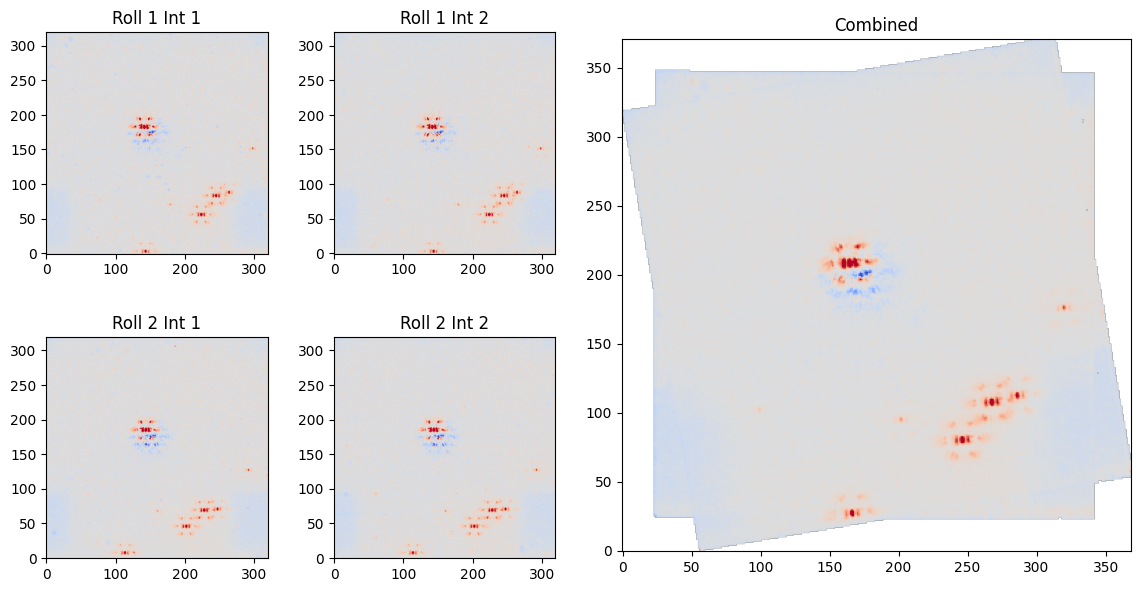

In [38]:
# Inspect the psf-subtracted images generated in the coron3 pipeline run
if docoron3:
    files = sorted(glob.glob(os.path.join(coron3_dir, '*_psfsub.fits')))
    grid = plt.GridSpec(2, 4, hspace=0.3, wspace=0.3)
    fig = plt.figure(figsize=(14, 7))

    # Plot the psf-subtracted science images for each roll and integration
    for roll in range(len(files)):
        data = fits.getdata(files[roll])
        for integ in range(data.shape[0]):
            data_int = data[integ]
            ax = fig.add_subplot(grid[roll, integ])
            ax.imshow(data_int, vmin=-2, vmax=2, origin='lower', cmap='coolwarm')
            ax.set_title('Roll {} Int {}'.format(roll + 1, integ + 1))

    # Plot the final combined psf-subtracted science image
    i2d_file = os.path.join(coron3_dir, f'{product_name}_i2d.fits')
    ax = fig.add_subplot(grid[0:2, 2:4])
    data = fits.getdata(i2d_file)
    ax.imshow(data, vmin=-2, vmax=2, origin='lower', cmap='coolwarm')
    ax.set_title('Combined')

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png' alt="stsci_logo" width="400px"/> 